# Further Processing Methylation Files Part 2
### Laurence Nickel (i6257119)

Libraries used: 
* pandas (version: '1.2.4')
* numpy (version: '1.20.1')
* matplotlib.pyplot (version: '3.3.4')
* seaborn (version: '0.11.1')
* plotly.express (version: '5.13.1')
* math (version: '3.8.8')
* sys (version: '3.8.8') 
* os (version: '3.8.8')
* random (version: '3.8.8')
* sklearn.impute (version: '0.24.1')
* sklearn.metrics (version: '0.24.1')
* sklearn.decomposition (version: '0.24.1')

References:

* [1] Jönsson, P., & Wohlin, C. (2006). Benchmarking k-nearest neighbour imputation with homogeneous Likert data. *Empirical Software Engineering, 11*(3), 463–489. doi: https://doi.org/10.1007/s10664-006-9001-9.
* [2] Liang, K. (2013). "3 - Transcriptomics," in *Bioinformatics for Biomedical Science and Clinical Applications* (Sawston, Cambridge, UK: Woodhead Publishing), 49-82.
* [3] Weinhold, L., Wahl, S., Pechlivanis, S., Hoffmann, P., & Schmid, M. (2016). A statistical model for the analysis of beta values in DNA methylation studies. *BMC Bioinformatics, 17*(1): 480. doi: https://doi.org/10.1186/s12859-016-1347-4.

## Introduction

Within this notebook, the methylation files downloaded within the notebook 'Loading Data.ipynb' and which were processed within the 'Further Processing Methylation Files Part 1.ipynb' notebook will be further processed where this notebook serves as the second part to the processing. The reason why I have decided to split up the further processing of the methylation files was already explained in the first part, but I can clarify it again. The first part is the most intuitive to perform in R (which includes normalizing the data, removing CpG sites with SNPs, and handle CpG site sample combinations that have a high p-value) while, this part, the second part is the most intuitive to perform in Python (which includes handling missing values, general exploratory data analysis, removing sites that are always methylated or never methylated, detecting potential outliers by using PCA, and transforming the methylation beta values to M-values).

### Importing libraries

Before we can start to further process the data present in the methylation file that was already processed in the notebook 'Further Processing Methylation Files Part 1.ipynb', we should first import some libraries that will be used throughout this notebook.

In [1]:
print("Starting the importing of the libraries...")


import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Here we first need to install the plotly library.
!pip install plotly
import plotly
import plotly.express as px

import math
import sys
import random
import os

import sklearn
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


print("Finishing the installing of the libraries.")

Starting the importing of the libraries...
Finishing the installing of the libraries.


Now that all the libraries have been imported, we can verify that these libraries have been loaded into this notebook by calling the version property of the library.

In [2]:
# Retrieving the version of the libraries to verify they have been correctly loaded into this notebook.
print("The library 'pd' (pandas) has been loaded into the notebook with its version being:")
print(pd.__version__)

print("\nThe library 'np' (numpy) has been loaded into the notebook with its version being:")
print(np.__version__)

print("\nThe library 'matplotlib' has been loaded into the notebook with its version being:")
print(matplotlib.__version__)

print("\nThe library 'sns' (seaborn) has been loaded into the notebook with its version being:")
print(sns.__version__)

print("\nThe library 'plotly' has been loaded into the notebook with its version being:")
print(plotly.__version__)

print("\nThe library 'sys' has been loaded into the notebook with its version being:")
print(sys.version)

print("\nThe library 'sklearn' has been loaded into the notebook with its version being:")
print(sklearn.__version__)

The library 'pd' (pandas) has been loaded into the notebook with its version being:
1.2.4

The library 'np' (numpy) has been loaded into the notebook with its version being:
1.20.1

The library 'matplotlib' has been loaded into the notebook with its version being:
3.3.4

The library 'sns' (seaborn) has been loaded into the notebook with its version being:
0.11.1

The library 'plotly' has been loaded into the notebook with its version being:
5.13.1

The library 'sys' has been loaded into the notebook with its version being:
3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]

The library 'sklearn' has been loaded into the notebook with its version being:
0.24.1


### Defining the data directories

In addition, we also need to define our data directories from which the files will be loaded and to which the resulting files will be stored. Please mind that these need to be changed to the desired directories to be able to work with the data directories.

In [3]:
data_directory_combined_not_cleaned_files = "C:/Users/laure/OneDrive/Documenten/Bachelor Thesis Data/combined_not_cleaned_data"
data_directory_combined_cleaned_files = "C:/Users/laure/OneDrive/Documenten/Bachelor Thesis Data/combined_cleaned_data"

## Further Processing Methylation File

To start the further processing of the methylation file, we first need to load it from the folder 'combined_not_cleaned_data'. This can be achieved by calling the function 'pd.read_csv()' with as a parameter the to be read methylation file.

In [5]:
# Loading the combined but not cleaned file 'all_methylation_data.csv'.
methylation_data = pd.read_csv(data_directory_combined_not_cleaned_files + '/methylation_data_partly_cleaned_containing_NaN.csv')

print("The 'methylation_data' DataFrame which is partly cleaned in the notebook 'Further Processing Methylation Files Part 1.ipynb'  but still contains NaN values:")
methylation_data

The 'methylation_data' DataFrame which is partly cleaned in the notebook 'Further Processing Methylation Files Part 1.ipynb'  but still contains NaN values:


CpG sites  TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  \
0            cg00050873             0.598401                  NaN   
1            cg00212031             0.148621                  NaN   
2            cg00213748             0.836599                  NaN   
3            cg00214611             0.032786                  NaN   
4            cg00455876             0.642416                  NaN   
...                 ...                  ...                  ...   
381301    ch.22.772318F             0.032142             0.143433   
381302  ch.22.43177094F             0.009543             0.006878   
381303    ch.22.909671F             0.111719             0.155722   
381304  ch.22.46830341F             0.010343             0.010581   
381305   ch.22.1008279F             0.015390             0.025336   

        TCGA-06-1804-01A-01  TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  \
0                       NaN                  NaN             0.474384   
1                       NaN                  NaN             0.041728   
2                       NaN                  NaN             0.081013   
3                       NaN                  NaN             0.030664   
4                       NaN                  NaN             0.501514   
...                     ...                  ...                  ...   
381301             0.196813             0.045382             0.030782   
381302             0.016276             0.004464             0.037535   
381303             0.208404             0.129313             0.071910   
381304             0.015248             0.010066             0.044211   
381305             0.016099             0.015632             0.011385   

        TCGA-14-0736-02A-01  TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  \
0                  0.695819             0.844931             0.616233   
1                  0.034927             0.033947             0.035452   
2                       NaN             0.748129                  NaN   
3                  0.032111             0.037053             0.029939   
4                       NaN             0.783247             0.664261   
...                     ...                  ...                  ...   
381301                  NaN             0.086724             0.061200   
381302             0.043951             0.007839             0.037672   
381303                  NaN             0.181898             0.111550   
381304             0.034146             0.010077             0.035975   
381305             0.016199             0.015469             0.014453   

        TCGA-19-5960-01A-11  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
0                  0.472024  ...             0.758095             0.872146   
1                  0.019626  ...             0.026595             0.036259   
2                  0.339565  ...             0.564641             0.846239   
3                  0.024187  ...             0.029693             0.025648   
4                  0.900718  ...             0.671254             0.814129   
...                     ...  ...                  ...                  ...   
381301             0.117800  ...             0.033715             0.024192   
381302             0.006655  ...             0.009374             0.014761   
381303             0.103455  ...             0.060410             0.048582   
381304             0.014086  ...             0.006724             0.014002   
381305             0.012466  ...             0.012878             0.009071   

        TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
0                       NaN             0.797791             0.785146   
1                       NaN                  NaN             0.031262   
2                       NaN                  NaN             0.893503   
3                       NaN                  NaN             0.037687   
4                       NaN             0.454763             0.830252   
...                     ...                  ...        

#### General Exploratory Data Analysis

The first thing we can do with the dataset is to perform some descriptive statistics on it. This can be achieved by calling the function 'describe()' on the 'methylation_data' DataFrame.

In [6]:
print("Descriptive statistics of the 'methylation_data' DataFrame:")
methylation_data_description = methylation_data.describe()
methylation_data_description

Descriptive statistics of the 'methylation_data' DataFrame:


TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  TCGA-06-1804-01A-01  \
count        381253.000000        380844.000000        380622.000000   
mean              0.510804             0.492850             0.488748   
std               0.387092             0.391562             0.395340   
min               0.004344             0.002784             0.003466   
25%               0.045475             0.042692             0.033772   
50%               0.564095             0.521008             0.510898   
75%               0.916530             0.910350             0.913256   
max               0.998240             0.997896             0.998791   

       TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  TCGA-14-0736-02A-01  \
count        380708.000000        380814.000000        368548.000000   
mean              0.482337             0.464064             0.504228   
std               0.399849             0.365011             0.388788   
min               0.002985             0.002510             0.004152   
25%               0.029957             0.038521             0.042252   
50%               0.500498             0.495248             0.575496   
75%               0.912563             0.821902             0.906816   
max               0.998944             0.998748             0.997012   

       TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  TCGA-19-5960-01A-11  \
count        381191.000000        380332.000000        381082.000000   
mean              0.534033             0.489863             0.520562   
std               0.403053             0.392098             0.409671   
min               0.001964             0.002811             0.002609   
25%               0.047040             0.038439             0.036826   
50%               0.662672             0.519937             0.622962   
75%               0.940484             0.907657             0.941217   
max               0.998606             0.998277             0.998499   

       TCGA-14-0781-01B-01  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
count        379700.000000  ...        381280.000000        381190.000000   
mean              0.520577  ...             0.501829             0.525914   
std               0.403142  ...             0.391162             0.397036   
min               0.002738  ...             0.003962             0.002797   
25%               0.041505  ...             0.039023             0.046070   
50%               0.623652  ...             0.552411             0.616207   
75%               0.937831  ...             0.911612             0.936747   
max               0.998980  ...             0.998075             0.998314   

       TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
count        380970.000000        380949.000000        381215.000000   
mean              0.505374             0.529265             0.433281   
std               0.399255             0.391504             0.386192   
min               0.002983             0.003092             0.002679   
25%               0.041192             0.047726             0.034271   
50%               0.555345             0.626654             0.337859   
75%               0.928526             0.926476             0.863119   
max               0.998888             0.997981             0.998407   

       TCGA-28-5208-01A-01  TCGA-12-5295-01A-01  TCGA-76-4931-01A-01  \
count        381106.000000        380947.000000        380461.000000   
mean              0.513363             0.507126             0.500943   
std               0.404966             0.380483             0.403599   
min               0.002547             0.002573             0.002538   
25%               0.038750             0.053288             0.037178   
50%               0.598875             0.551442             0.561896   
75%               0.933431             0.901444             0.925933   
max               0.998631             0.999084             0.998588   

       TCGA-06-0190-02A-01  TCGA-76-4929-01A-01  
count        38107

Although this does already provide us with quite some information, not every sample is displayed in the output above due to there being 65 samples in the 'methylation_data' DataFrame. To better visualize these results, we can create plots displaying the descriptive statistics. Mind that these plots are not meant for looking up certain descriptive statistics per se (although they can be used for this), but rather to show the general distribution of the specific descriptive statistic.

##### count

In [7]:
# Getting the counts of all the samples.
counts = methylation_data_description.transpose()['count']

# Plotting them in a bar chart using the function 'px.bar()'.
fig = px.bar(x=counts.index, y=counts)
fig.update_xaxes(tickangle=80)
fig.update_layout(title={'text': 'The counts of all the samples for the methylation data', 'x':0.5},
                  xaxis_title='The samples',
                  yaxis_title='The count value')
fig.update_layout(width=1070, height=600)
fig.show()

As we can see from output above, it seems like all the counts for every sample are fairly similar but not exactly the same. Of course, the number of rows are the same for every sample, but there is a difference in the counts for the samples which might be caused by there appearing NaN values within the samples. To verify this, we can run the code below which calls the function 'isna()' to check whether there exits NaN values within the DataFrame.

In [14]:
# Checking whether there exist NaN values within the 'methylation_data' DataFrame. This can be achieved by calling the 
# function 'isna()' followed by calling the function 'any()' twice. The reason for having a double 'any()' call in the code 
# is to check if there are any True values in the boolean DataFrame that is returned by the 'isna()' function.
if not methylation_data.isna().any().any():
    print("Every value in the 'methylation_data' DataFrame is not NaN.")
else:
    print("There are NaN values in the 'methylation_data' DataFrame.")

There are NaN values in the 'methylation_data' DataFrame.


As given by the output above, indeed as expected there exist NaN values within the 'methylation_data' DataFrame. These will be handled in the section 'Handling rows which only contain missing values'.

##### mean

In [15]:
# Getting the means of all the samples.
means = methylation_data_description.transpose()['mean']

# Plotting them in a bar chart using the function 'px.bar()'.
fig = px.bar(x=means.index, y=means)
fig.update_xaxes(tickangle=80)
fig.update_layout(title={'text': 'The means of all the samples for the methylation data', 'x':0.5},
                  xaxis_title='The samples',
                  yaxis_title='The mean value')
fig.update_layout(width=1070, height=600)
fig.show()

As we can see from output above, it seems like all the means for every sample are different. Another thing we can conclude from the output above is that most of the samples have a mean being relatively close to 0.5, which makes sense since we expect the distribution of each sample to contain two peaks (one close to 0 and one close to 1) where both of them have relatively the same height.

##### standard deviation

In [16]:
# Getting the standard deviation of all the samples.
std = methylation_data_description.transpose()['std']

# Plotting them in a bar chart using the function 'px.bar()'.
fig = px.bar(x=std.index, y=std)
fig.update_xaxes(tickangle=80)
fig.update_layout(title={'text': 'The standard deviations of all the samples for the methylation data', 'x':0.5},
                  xaxis_title='The samples',
                  yaxis_title='The standard deviation value')
fig.update_layout(width=1070, height=600)
fig.show()

As we can see from the ouput above, the standard deviation is a little bit different across the samples. They do not differ too much, however, which makes sense since the methylation values are always between 0 and 1.

##### median

In [17]:
# Getting the median of all the samples.
medians = methylation_data_description.transpose()['50%']

# Plotting them in a bar chart using the function 'px.bar()'.
fig = px.bar(x=medians.index, y=medians)
fig.update_xaxes(tickangle=80)
fig.update_layout(title={'text': 'The medians of all the samples for the methylation data', 'x':0.5},
                  xaxis_title='The samples',
                  yaxis_title='The median value')
fig.update_layout(width=1070, height=600)
fig.show()

As we can see from output above, it seems like all the medians for every sample are different. Another thing we can conclude from the output above is that most of the samples have a median being relatively close to 0.5, which makes sense since we expect the distribution of each sample to contain two peaks (one close to 0 and one close to 1) where both of them have relatively the same height. There are, however, a few samples which are +- 0.2 (or even +- 0.4) away from 0.5. The sample 'TCGA-06-5416-01A-01' has a really low median of roughly 0.12 indicating that the peak of values close to 0 is much higher than the peak close to 1.

##### minimum value

In [18]:
# Getting the minimum value of all the samples.
minimum = methylation_data_description.transpose()['min']

# Plotting them in a bar chart using the function 'px.bar()'.
fig = px.bar(x=minimum.index, y=minimum)
fig.update_xaxes(tickangle=80)
fig.update_layout(title={'text': 'The minimum values of all the samples for the methylation data', 'x':0.5},
                  xaxis_title='The samples',
                  yaxis_title='The minimum value')
fig.update_layout(width=1070, height=600, yaxis_range=[0,1])
fig.show()

As we can see from the output above, bars are visible for each of the samples but these are all really low. If we hover over the bars separately, we can see that the lowest values found for each sample hover around 0.001 but are never 0. It actually makes sense that these values are never zero as the chance of this happening is very slim considering that millions of cells are measured whether they are methylated or not, and some of them will be methylated even though if it is by chance. 

##### maximum value

In [19]:
# Getting the maximum value of all the samples.
maximum = methylation_data_description.transpose()['max']

# Plotting them in a bar chart using the function 'px.bar()'.
fig = px.bar(x=maximum.index, y=maximum)
fig.update_xaxes(tickangle=80)
fig.update_layout(title={'text': 'The maximum values of all the samples for the methylation data', 'x':0.5},
                  xaxis_title='The samples',
                  yaxis_title='The maximum value')
fig.update_layout(width=1070, height=600)
fig.show()

As we can see from the output above, all the bars for each of the samples are really close to 1. If we hover over the bars separately, we can see that the highest values found for each sample hover around 0.99 but are never 1. It actually makes sense that these values are never equal to 1 as the chance of this happening is very slim considering that millions of cells are measured whether they are methylated or not, and some of them will be not methylated even though if it is by chance. The chance of all of them being methylated is very small.

<br/><br/>
After having performed this simple form of exploratory analysis, we can check whether all the CpG sites present in the 'methylation_data' DataFrame are unique. This can be achieved by calling the function 'duplicated()' followed by the function 'any()' on the 'CpG sites' column to discover whether there exists more than 1 record for any CpG site.

In [20]:
unique_sites = methylation_data['CpG sites'].duplicated().any()
if unique_sites:
    print("There are duplicate CpG sites.")
else:
    print("All CpG sites are unique.")

All CpG sites are unique.


As we can see from the output above, all the CpG sites are unique indicating that there does not exist more than 1 record for any CpG site.

Next, another form of analysis we can perform is to discover what kind of values we are dealing with. The first thing we can do is to check whether we only have values between 0 and 1 (which was already shown by the plots above but we can verify this again). From the output above we can see that NaN values appear within the DataFrame, so therefore we will here not examine these cells which contain NaN for checking whether all the values fall between 0 and 1. At the same time, we can also compute what the minimum and maximum values are and how many cells with real values there are and also how many cells with NaN values there are. After retrieving these counts we can deduce whether any other entries appear within the cells that are not expected such as a string.

In [23]:
num_total_values = 0
num_values_between_0_and_1 = 0
num_NaN = 0
all_values = []
minimum_value = float('inf')
maximum_value = float('-inf')

for row in methylation_data.itertuples(index=False):
    for value in row[1:]:
        num_total_values = num_total_values + 1
        if math.isnan(value):
            num_NaN = num_NaN + 1
        elif not math.isnan(value) and not math.isinf(value):
            all_values.append(value)
            if value >= 0 and value <= 1:
                num_values_between_0_and_1 = num_values_between_0_and_1 + 1
            if value > maximum_value:
                maximum_value = value
            if value < minimum_value:
                minimum_value = value

print("The expected number of total cells: 381306 * 65 = 24784890")
print("The computed number of total cells: " + str(num_total_values) + "\n")
print("The computed number of cells containing real values between 0 and 1: " + str(num_values_between_0_and_1))
print("The computed number of cells containing NaN values: " + str(num_NaN) + "\n")
print("The total number of cells containing real values between 0 and 1 and cells containing NaN values (should equal 24784890): " + str(num_values_between_0_and_1+num_NaN) + "\n")
print("The minimum real value found: " + str(minimum_value))
print("The maximum real value found: " + str(maximum_value))

The expected number of total cells: 381306 * 65 = 24784890
The computed number of total cells: 24784890

The computed number of cells containing real values between 0 and 1: 24735743
The computed number of cells containing NaN values: 49147

The total number of cells containing real values between 0 and 1 and cells containing NaN values (should equal 24784890): 24784890

The minimum real value found: 0.0017795490502426
The maximum real value found: 0.999444563552373


The first thing we can see from the ouput above is that there are no cells containing any unexpected content as the number of cells containing real values added to the number of cells containing NaN values is exactly equal to the total number of cells present in the DataFrame. We can also see from the output that there only exist real values between 0 and 1 within the DataFrame as the minimum real value found is larger than 0 and the maximum real value found is smaller than 1. We also notice that the minimum value across all entries is quite close to 0 while the maximum value across all entries is quite close to 1. 

### Handling rows which only contain missing values

Another thing that we noticed from the output above is that there are quite a lot of NaN values in the 'methylation_data' DataFrame. These represent missing values and it is certain that we need to handle them before we can apply the different machine learning techniques as these are often not designed to work with missing values. Therefore, we need to ensure that <u>all</u> missing values will be handled one way or another. 

We can first look at all the CpG sites which have missing values for all the 65 samples (case ids) as these could be removed immediately. This can be achieved by calling on all the columns separately the function 'isnull()' followed by calling the function 'all()' such that only the CpG sites where all the entries are equal to NaN remain.

In [24]:
# Retrieving only the columns that have methylation values present in their cells.
columns_to_check = methylation_data.columns[1:]

# Retrieving all the rows (CpG sites) where every column present in the 'columns_to_check' has for the current row
# the value NaN.
methylation_sites_all_nan = methylation_data[methylation_data[columns_to_check].isnull().all(axis=1)]
methylation_sites_all_nan

Empty DataFrame
Columns: [CpG sites, TCGA-06-0211-01A-01, TCGA-26-5136-01B-01, TCGA-06-1804-01A-01, TCGA-06-5408-01A-01, TCGA-19-4065-01A-01, TCGA-14-0736-02A-01, TCGA-06-5415-01A-01, TCGA-06-0221-02A-11, TCGA-19-5960-01A-11, TCGA-14-0781-01B-01, TCGA-28-5209-01A-01, TCGA-19-4065-02A-11, TCGA-06-5858-01A-01, TCGA-26-5133-01A-01, TCGA-28-5215-01A-01, TCGA-26-5135-01A-01, TCGA-06-0152-02A-01, TCGA-19-1389-02A-21, TCGA-28-5216-01A-01, TCGA-28-5207-01A-01, TCGA-76-4926-01B-01, TCGA-28-5220-01A-01, TCGA-06-AABW-11A-31, TCGA-41-5651-01A-01, TCGA-06-5859-01A-01, TCGA-76-4925-01A-01, TCGA-28-5204-01A-01, TCGA-15-1444-01A-02, TCGA-06-0125-02A-11, TCGA-76-4928-01B-01, TCGA-28-2510-01A-01, TCGA-06-5416-01A-01, TCGA-32-1980-01A-01, TCGA-06-0210-02A-01, TCGA-06-0210-01A-01, TCGA-32-5222-01A-01, TCGA-14-1034-02B-01, TCGA-06-0125-01A-01, TCGA-06-5411-01A-01, TCGA-28-5218-01A-01, TCGA-06-5410-01A-01, TCGA-06-5417-01A-01, TCGA-06-5856-01A-01, TCGA-76-4932-01A-01, TCGA-12-5299-01A-02, TCGA-26-5139-01A-01, TCGA-28-5213-01A-01, TCGA-26-1442-01A-01, TCGA-06-5414-01A-01, TCGA-06-5413-01A-01, TCGA-26-5132-01A-01, TCGA-19-0957-02A-11, TCGA-06-0211-02A-02, TCGA-76-4927-01A-01, TCGA-06-5412-01A-01, TCGA-06-0190-01A-01, TCGA-06-0171-02A-11, TCGA-06-5418-01A-01, TCGA-14-1402-02A-01, TCGA-26-5134-01A-01, TCGA-28-5208-01A-01, TCGA-12-5295-01A-01, TCGA-76-4931-01A-01, TCGA-06-0190-02A-01, TCGA-76-4929-01A-01]
Index: []

[0 rows x 66 columns]

As we can see from the output above, there are in total 0 CpG sites for which all of the 65 samples have NaN as the corresponding value.

### Handling rows which contain some missing values

Since we have not removed any CpG sites yet, there are still some NaN values appearing within the 'methylation_data' DataFrame. We should handle these missing values as, as mentioned before, these NaN values cannot be used within the machine learning techniques. 

We can create some more intuition about where these NaN values appear by computing how many are present for each CpG site. Here it is important to remember that the total number of samples is 65 and considering that there were no rows present for which all 65 samples the value was NaN, the maximum number of NaN values possible within a row at this point is 64.

#### Displaying where the missing values appear

In [26]:
# Creating a copy of the 'methylation_data' DataFrame to store the computations performed (such that the original DataFrame
# is left unaltered).
methylation_data_copy = methylation_data.copy()

# Counting the number of NaN values per CpG site starting from the second column (as the first column contains the
# CpG site itself) and storing its result in a new column.
methylation_data_copy['number_of_nan'] = methylation_data_copy.iloc[:, 1:].isnull().sum(axis=1)

# Next, we can perform a 'groupby' operation on the number of NaN values per row and count the frequencies.
frequency_nan = methylation_data_copy.groupby('number_of_nan').size()
print("The frequencies of the number of NaN per row where every row of the 'methylation_data' DataFrame is taken into account:")
frequency_nan

The frequencies of the number of NaN per row where every row of the 'methylation_data' DataFrame is taken into account:


number_of_nan
0     365835
1       9184
2       2687
3        993
4        513
5        312
6        259
7        178
8        144
9        121
10        97
11        82
12        64
13        58
14        69
15        40
16        30
17        31
18        40
19        28
20        20
21        25
22        26
23        23
24        26
25        25
26        26
27        42
28        66
29       120
30        35
31        10
32         8
33         9
34         7
35         3
36        10
37         2
38         5
39         4
40         7
41         3
42         6
43         1
44         3
45         3
46         5
47         3
48         6
49         1
51         1
53         2
54         2
56         3
58         1
62         1
63         1
dtype: int64

This does already provide us with some intuition, but we can better visualize these frequencies by plotting them into a bar plot which can be achieved by calling the function 'plt.bar()'. 

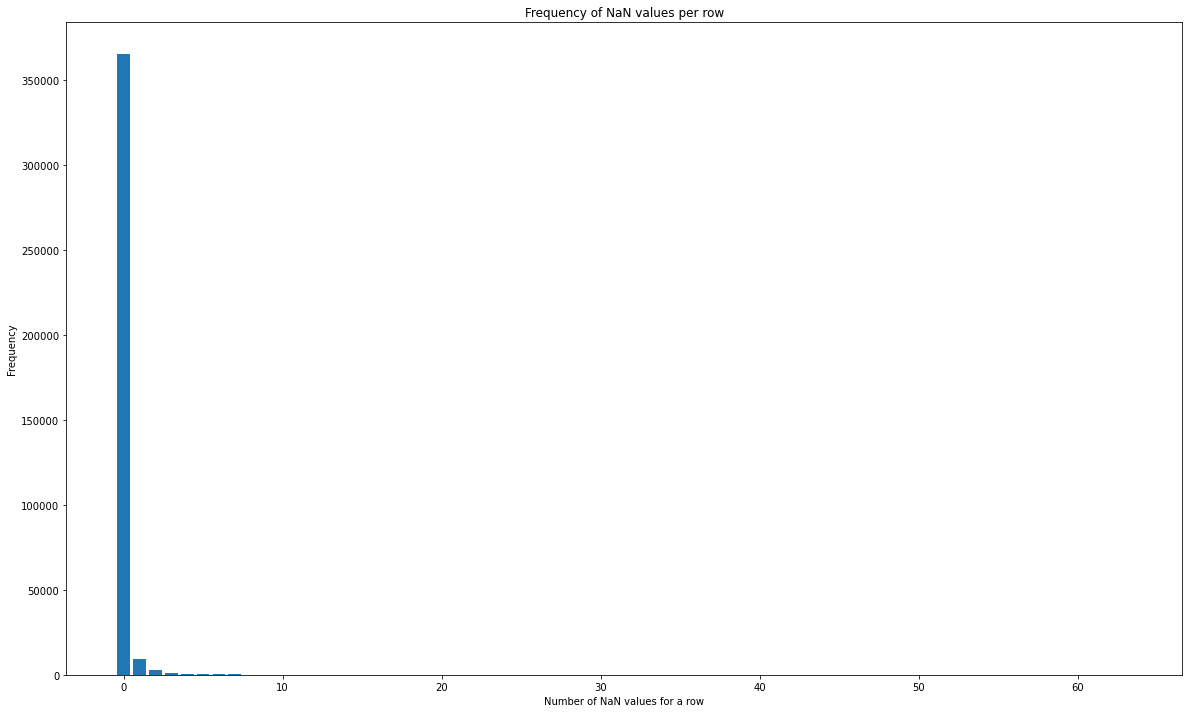

In [27]:
plt.figure(figsize=(20, 12))

# Visualizing the frequencies of the number of NaN per row where every row of the 'methylation_data' DataFrame is taken into 
# account.
plt.bar(frequency_nan.index.tolist(), frequency_nan.values.tolist())
plt.xlabel('Number of NaN values for a row')
plt.ylabel('Frequency')
plt.title('Frequency of NaN values per row')
plt.show()

As expected from the frequencies displayed before, the number of NaN values in a row being equal to 0 and also 1 compared to the other bars are quite high. Although this is great to see as we want the rows to contain as few missing values as possible, it is not quite clear how large the frequencies of NaN values in a row are for the number of NaN values in a row being greater than 20. Therefore, another bar plot is created below which excludes the 0 and 1 bars, but it is important to note that the other frequencies remain the same.

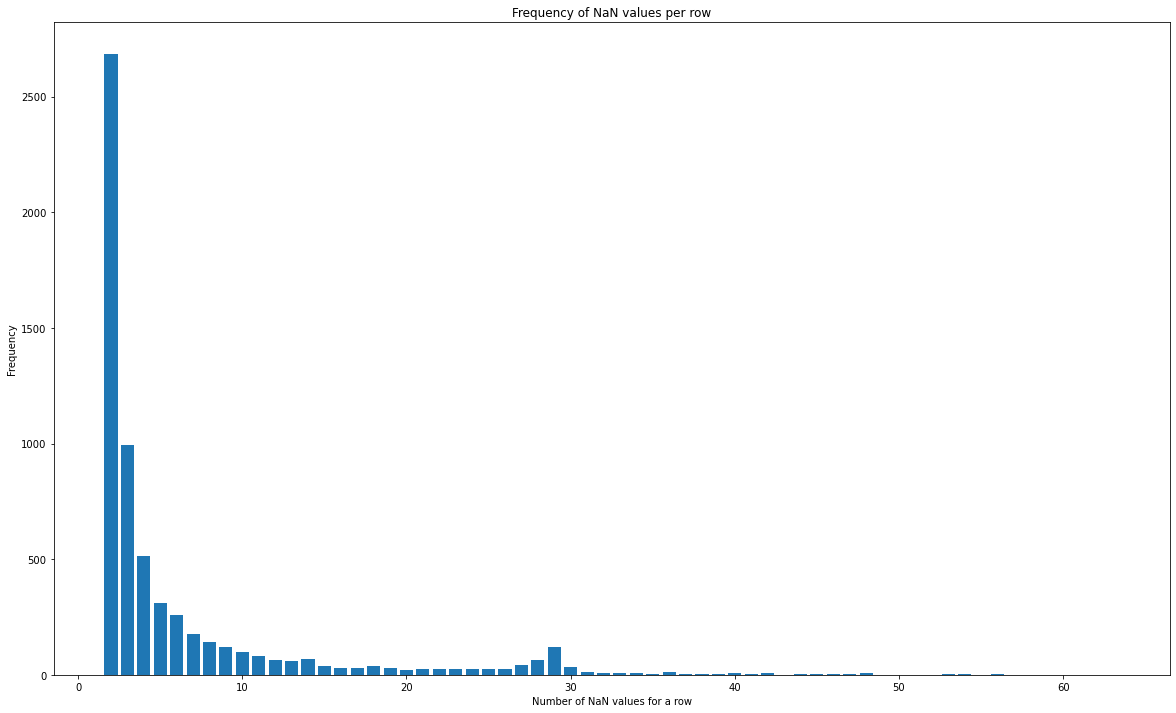

In [28]:
plt.figure(figsize=(20, 12))

# Visualizing the frequencies of the number of NaN per row where every row of the 'methylation_data' DataFrame is taken into 
# account except the 0 and 1 bars.
plt.bar(frequency_nan.index.tolist()[2:], frequency_nan.values.tolist()[2:])
plt.xlabel('Number of NaN values for a row')
plt.ylabel('Frequency')
plt.title('Frequency of NaN values per row')
plt.show()

Now it is indeed more clear how large the frequencies of NaN values in a row are for a larger number of NaN values in a row.

Since I do not want to remove any additional CpG sites when not absolutely needed I will use imputation to substitute the missing values with values that would be expected to occur in those cells. The approach that will be used for this is the k-nearest neighbors algorithm where the k nearest neighbors, the most similar samples to the current sample, are used to determine the value of the cell which currently contains 'NaN'. There is a problem with using this approach as executing the algorithm on rows which contain a high number of NaN values (close to 64) will after imputation contain a lot of values that are nearly duplicated or completely duplicated. Basing the values the whole row on just a few known values (using 1-5 values to predict 64-60 values) does not seem right as we know that there will naturally be some fluctuations within a row. This problem does not just occur for the rows where the number of NaN values is close to 64, but in general we do not know how many non NaN values are needed within a row to make accurate predictions. Naturally, since the cells contain missing values there is then no way of determining whether the prediction made was accurate or not when using this method on the entire dataset.

One thing that we can do, however, is to retrieve a subset of the data that is complete and for some of the rows randomly remove (set to NaN) n cells. The following step is then to perform our k-nearest neighbors algorithm to predict the cells containing the missing values and examining how accurate the predictions were. We can calculate how accurate the predictions were as we still know which values the cells originally contained. For the next iteration we can then increase the number of cells we set to NaN by 1 (in the original complete subset that we created for this part) and calculate the accuracies of the predictions here. By increasing the number of cells we set to NaN, we can eventually compute for which number of NaNs in a row the predictions become too inaccurate. With this we can conclude how many NaN values there can appear in a row for the k-nearest neighbors algorithm to still make an accurate prediction for the missing values. In the original DataFrame 'methylation_data' we can then remove the rows which contain a number of NaN values that is higher than the number that the k-nearest neighbors algorithm can still accurately predict. It would be best to remove these rows as we do not want inaccurate information to be used later in the machine learning techniques.

#### Identifying which number of missing values within a row k-nearest neigbors can handle

The first step to the approach mentioned above is to retrieve a complete subset from the DataFrame 'methylation_data' where complete means that no missing values are present within the dataset. The most simple approach to achieve this is by retrieving all the CpG sites for which none of the cells belonging to the row contain any missing values.

In [29]:
# Retrieving only the columns that have methylation values present in their cells.
columns_to_check = methylation_data.columns[1:]

# Retrieving all the rows (CpG sites) where every column present in the 'columns_to_check' has for the current row
# a real value meaning that no missing value (NaN value) within the rows exist.
complete_subset = methylation_data[~methylation_data[columns_to_check].isnull().any(axis=1)]
complete_subset

CpG sites  TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  \
10           cg02494853             0.024200             0.012156   
19           cg03706273             0.013504             0.018078   
23           cg04023335             0.409555             0.104077   
31           cg04964672             0.976162             0.786973   
32           cg05213048             0.949475             0.827611   
...                 ...                  ...                  ...   
381299    ch.22.740407F             0.017298             0.014690   
381300    ch.22.757911F             0.022103             0.043642   
381302  ch.22.43177094F             0.009543             0.006878   
381304  ch.22.46830341F             0.010343             0.010581   
381305   ch.22.1008279F             0.015390             0.025336   

        TCGA-06-1804-01A-01  TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  \
10                 0.303783             0.009281             0.228710   
19                 0.017174             0.015129             0.011728   
23                 0.108222             0.038975             0.276064   
31                 0.738651             0.691022             0.663920   
32                 0.896278             0.942900             0.601283   
...                     ...                  ...                  ...   
381299             0.013254             0.016126             0.018505   
381300             0.072143             0.042548             0.018132   
381302             0.016276             0.004464             0.037535   
381304             0.015248             0.010066             0.044211   
381305             0.016099             0.015632             0.011385   

        TCGA-14-0736-02A-01  TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  \
10                 0.012509             0.306980             0.011436   
19                 0.017406             0.014066             0.011170   
23                 0.676820             0.887582             0.303421   
31                 0.947670             0.977891             0.911585   
32                 0.793935             0.965785             0.462555   
...                     ...                  ...                  ...   
381299             0.029466             0.011896             0.014477   
381300             0.037516             0.037702             0.037085   
381302             0.043951             0.007839             0.037672   
381304             0.034146             0.010077             0.035975   
381305             0.016199             0.015469             0.014453   

        TCGA-19-5960-01A-11  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
10                 0.011622  ...             0.018084             0.135107   
19                 0.011928  ...             0.012472             0.013400   
23                 0.854826  ...             0.737478             0.743077   
31                 0.981444  ...             0.930725             0.979646   
32                 0.593934  ...             0.753453             0.824493   
...                     ...  ...                  ...                  ...   
381299             0.015716  ...             0.013696             0.012407   
381300             0.084058  ...             0.019164             0.016521   
381302             0.006655  ...             0.009374             0.014761   
381304             0.014086  ...             0.006724             0.014002   
381305             0.012466  ...             0.012878             0.009071   

        TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
10                 0.047235             0.017001             0.010022   
19                 0.021490             0.364303             0.012748   
23                 0.056864             0.150711             0.389690   
31                 0.867662             0.837983             0.963548   
32                 0.888518             0.913138             0.904776   
...                     ...                  ...        

We can verify whether these CpG sites do indeed not contain any missing values.

In [30]:
# Checking whether all the CpG sites in the 'complete_subset' DataFrame do indeed not contain any missing values.
# This can be achieved by calling the function 'isna()' followed by calling the function 'any()' twice. The reason for 
# having a double 'any()' call in the code is to check if there are any True values in the boolean DataFrame that is 
# returned by the 'isna()' function.
if not complete_subset.isna().any().any():
    print("Every value in the 'complete_subset' DataFrame is not NaN.")
else:
    print("There are NaN values in the 'complete_subset' DataFrame.")

Every value in the 'complete_subset' DataFrame is not NaN.


It must be noted that we will be working under the assumption that the pattern of randomness in the subset of the dataset (the 'complete_subset' DataFrame) is the same as in the original dataset meaning that we can assume that the results of the k-nearest neighbors algorithm running on the subset of the dataset, how many NaN values within the same row can be accurately predicted, do also apply when running the k-nearest neighbors algorithm on the entire dataset (so this number of NaN values within the same row that can be accurately predicted is the same for both the subset of the dataset and the entire dataset). To avoid the complete subset being biased towards certain ranges of values or certain combinations of features which can lead to overestimation or underestimation of the algorithm's accuracy and can result in poor performance when the algorithm is applied to unseen data, a subset of the rows is randomly selected from the complete subset to use for evaluation to possibly help mitigate the risk of bias. Randomly selecting a subset of rows can help to ensure that any specific patterns or biases in the complete subset are not driving the evaluation results.

In [32]:
# Randomly selecting a subset of rows can help to ensure that any specific patterns or biases in the complete subset are not 
# driving the evaluation results. This can be achieved by calling the function 'sample()' with as parameters the number of 
# total rows in the 'complete_subset' matrix and the number of rows we want to select.
complete_subset_sampled = complete_subset.sample(n=1000, replace=False)

# Another thing we can do is remove the first column of the 'complete_subset_sampled' DataFrame featuring the Methylation 
# Sites as this is not relevant for finding the number of NaN values that can appear in a row for the k-nearest neighbors 
# algorithm to still make an accurate prediction for the missing values.
complete_subset_sampled.drop('CpG sites', axis=1, inplace=True)

# In addition, we can also reset the index of the 'complex_subset_sampled' DataFrame by calling the function 'reset_index()'.
complete_subset_sampled.reset_index(drop=True, inplace=True)

print('The sampled complete subset of the methylation data:')
complete_subset_sampled

The sampled complete subset of the methylation data:


TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  TCGA-06-1804-01A-01  \
0               0.028434             0.582220             0.554933   
1               0.016282             0.020863             0.014351   
2               0.563612             0.781695             0.845277   
3               0.419118             0.637180             0.405424   
4               0.021549             0.030923             0.031703   
..                   ...                  ...                  ...   
995             0.669301             0.591375             0.649877   
996             0.498058             0.851378             0.901579   
997             0.976045             0.950467             0.971275   
998             0.969954             0.671206             0.344926   
999             0.023395             0.020765             0.012195   

     TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  TCGA-14-0736-02A-01  \
0               0.292418             0.027734             0.022226   
1               0.017582             0.011115             0.015500   
2               0.824730             0.601924             0.956141   
3               0.497826             0.604714             0.529586   
4               0.018303             0.019533             0.024670   
..                   ...                  ...                  ...   
995             0.632431             0.469410             0.661867   
996             0.899666             0.458783             0.810074   
997             0.974918             0.984983             0.984370   
998             0.837314             0.876867             0.657369   
999             0.015762             0.021951             0.023405   

     TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  TCGA-19-5960-01A-11  \
0               0.018548             0.042122             0.016394   
1               0.023289             0.018315             0.013569   
2               0.963321             0.380677             0.978256   
3               0.659273             0.475461             0.701768   
4               0.027503             0.023105             0.019507   
..                   ...                  ...                  ...   
995             0.820687             0.478091             0.547736   
996             0.900171             0.249768             0.849902   
997             0.978000             0.981992             0.943839   
998             0.969111             0.753076             0.233399   
999             0.021900             0.022471             0.011263   

     TCGA-14-0781-01B-01  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
0               0.039753  ...             0.037356             0.022976   
1               0.019396  ...             0.015827             0.014625   
2               0.992089  ...             0.951761             0.927588   
3               0.509912  ...             0.616868             0.417869   
4               0.025468  ...             0.023990             0.024173   
..                   ...  ...                  ...                  ...   
995             0.661565  ...             0.591449             0.598649   
996             0.944621  ...             0.864953             0.832959   
997             0.957961  ...             0.979194             0.985812   
998             0.905476  ...             0.859561             0.940333   
999             0.009427  ...             0.023394             0.026411   

     TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
0               0.325178             0.560453             0.022457   
1               0.022939             0.012294             0.018566   
2               0.646936             0.814491             0.951856   
3               0.892755             0.873313             0.243490   
4               0.020549             0.019620             0.029503   
..                   ...                  ...                  ...   
995             0.788640             0.677962             0.372153   
996             0.881

We can now use this sampled complete subset of the data to implement the approach discussed above to find the number of NaN values that can appear in a row for the k-nearest neighbors algorithm to still make an accurate prediction for the missing values. 

Before we can start experimenting with different number of NaN values we can randomly remove from a row, which we can call from this point onwards 'n', we first need to define which k we want to use the serve as the k within the k-nearest neighbors algorithm. This can be achieved by looping over every k value which ranges from 1 to 30. For each k, we artifically add 20 missing values to each of the rows of the 'complete_dataset_sampled' and take, for each k, the average RMSE (root-mean-squared error) will be calculated. At the end, the k with the best accuracy (lowest RMSE value) is chosen to serve as the k within the k-nearest neighbors algorithm to be used later to discover how many NaN values there can appear in a row for the k-nearest neighbors algorithm to still make an accurate prediction for the missing values.

To improve the efficiency of the different computations that will be performed next, we can convert the 'complete_subset_sampled' DataFrame to a Numpy array. In addition, since the 'KNNImputer()' class that will be used later assumes that the rows represent the samples (which should be the case ids) we need to tranpose our array such that our samples (the case ids) appear as the rows.

In [33]:
# Converting the 'complete_subset_sampled' DataFrame to a numpy array.
sampled_subset_array = complete_subset_sampled.values

# Transposing the 'sampled_subset' numpy array.
sampled_subset_array_T = sampled_subset_array.transpose()

In [34]:
print('The converted \'sampled_subset\' transposed (the rows represent the case ids and the columns the CpG sites):')
sampled_subset_array_T

The converted 'sampled_subset' transposed (the rows represent the case ids and the columns the CpG sites):


array([[0.02843369, 0.01628159, 0.5636123 , ..., 0.97604525, 0.96995436,
        0.02339492],
       [0.58222002, 0.0208633 , 0.78169539, ..., 0.95046728, 0.67120629,
        0.02076508],
       [0.55493307, 0.01435125, 0.84527676, ..., 0.97127452, 0.34492579,
        0.01219522],
       ...,
       [0.32425334, 0.02691684, 0.83939331, ..., 0.96606301, 0.91213541,
        0.01434077],
       [0.03009221, 0.02109152, 0.81101068, ..., 0.98807206, 0.97063873,
        0.02169616],
       [0.64097711, 0.0195167 , 0.84447428, ..., 0.97141366, 0.62174594,
        0.02223609]])

In [35]:
# This function randomly removes 20 cells from column 'm'.
def randomly_remove_20_cells_from_column_m(m):
    # We first create a copy of the 'sampled_subset_array_T' numpy array such that we do not alter it, as we need it for 
    # multipe iterations.
    temporary_copy = sampled_subset_array_T.copy()
    
    # Retrieving a list of random indices in between and including 0 and 65 of size 20. These indices are then set to 'NaN'
    # in the copied array which is returned after.
    list_of_indices = random.sample(range(0, 65), 20)
    for i in list_of_indices:
        temporary_copy[i,m] = np.nan
    
    return temporary_copy

# Initializing a list that will store all the average RMSE values.
k_accuracies_general =[]

# Since the computation below takes quite some time, a boolean is used to easily 'turn it on and off' when needed.
computation_not_performed_yet = True
if computation_not_performed_yet:
    # Performing the computation below 25 times.
    for j in range(25):
        k_accuracies = []
        # Looping over all the possible k's to serve as the k in the k-nearest neighbors algorithm.
        for k in range(1, 31):
            # Initializing a new k-nearest neighbor imputer by calling the class 'KNNImputer()'.
            knn_imputer = KNNImputer(n_neighbors=k)
            temporary_rmse_k = []

            # For every k, the insertion of NaN values is performed for every column present in the 'sampled_subset_array_T' and 
            # the average RMSE is taken for every column and is added to the 'k_accuracies'.
            for m in range(len(sampled_subset_array_T)):
                # Randomly removing 20 cells from column 'm', predicting the values using the 'KNNImputer()' class and evaluating 
                # these predictions by calculating the root-mean-squared error (which is achieved by setting the parameter 
                # 'squared' in the 'mean_squared_error' to False).
                df_one_column_missing_values = randomly_remove_20_cells_from_column_m(m)
                df_filled = knn_imputer.fit_transform(df_one_column_missing_values)
                rmse = mean_squared_error(sampled_subset_array_T[:,m], df_filled[:,m], squared=False)
                temporary_rmse_k.append(rmse)

            # Calculating the average RMSE value for the current k by calling the function 'np.mean()' and adding it to the 
            # 'k_accuracies'.
            k_accuracies.append(np.mean(temporary_rmse_k))
    k_accuracies_general.append(k_accuracies)
computation_not_performed_yet = False

# Computing the mean of each element across the 10 lists in 'k_accuracies_general'.
k_accuracies_final = [sum(x) / len(x) for x in zip(*k_accuracies_general)]

Now we can use this 'k_accuracies_final' list to find the k with the best accuracy (lowest RMSE value). This can be achieved by calling the functions 'index()' and 'min()'. Mind that we need to add 1 to the retrieved value of k since our list starts for k=1 while indexing starts at 0.

In [36]:
# Converting the list 'k_accuracies_final' to a DataFrame with two columns.
k_acc = pd.DataFrame({'The k values': range(1, len(k_accuracies_final)+1),
                   'The RMSE value': k_accuracies_final})

# Plotting the list 'k_accuracies_final' by using the Plotly library.
fig = px.line(k_acc, x='The k values', y='The RMSE value')
fig.update_layout(title={'text': 'The accuracies for all the k\'s', 'x':0.5},
                  xaxis_title='The k value',
                  yaxis_title='The RMSE value')
fig.update_yaxes(tickformat=".6f")
fig.show()

Before we discuss the plot above, please mind that rerunning the code above causes the plot to change its appearance which is described below. As we can see from the plot above, we can observe that having a very low or very high k is not really efficient. The best values for k seem to be around 3-12, where after this range of k values the RMSE value seems to increase (indicating the accuracy decreases). Since it is often recommended to use the root of the number of samples for the value of k (when no other form of hyperparameter tuning has taken place), we can therefore opt to choose k to be equal to 8 here as this also falls within the range mentioned before [1]. This k will now serve as the k within the k-nearest neighbors algorithm to discover how many NaN values there can appear in a row for the k-nearest neighbors algorithm to still make an accurate prediction for the missing values. This is performed below. Here, we loop over all the possible n's (which represent how many NaN values are inserted into a row) and calculate the RMSE value for the (k,n) combination. To get a better approximation of the accuracy of the (k,n) combination, the RMSE value will be calculated by averaging the RMSE values computed when a single row (one at a time; eventually all rows once for each n) has n missing values. Here it is important to mention that since k=8, n can be at most 64-k = 64-8 = 56.

In [37]:
# This function randomly removes 'n' cells from column 'm'.
def randomly_remove_n_cells_from_column_m(n, m):
    # We first create a copy of the 'sampled_subset_array_T' numpy array such that we do not alter it, as we need it for 
    # multipe iterations.
    temporary_copy = sampled_subset_array_T.copy()
    
    # Retrieving a list of random indices in between and including 0 and 65 of size 'n'. These indices are then set to 'NaN'
    # in the copied array which is returned after.
    list_of_indices = random.sample(range(0, 65), n)
    for i in list_of_indices:
        temporary_copy[i,m] = np.nan
    
    return temporary_copy

# Initializing a list that will store all the average RMSE values.
n_accuracies = []

# Since the computation below takes quite some time, a boolean is used to easily 'turn it on and off' when needed.
computation_not_performed_yet = True
if computation_not_performed_yet:
    # Initializing a new k-nearest neighbor imputer by calling the class 'KNNImputer()'.
    knn_imputer = KNNImputer(n_neighbors=8)
    
    # Looping over all the possible n's which represent how many NaN values are inserted into a column.
    for n in range(1, 57):
        temporary_rmse_n = []
        
        # This insertion of NaN values is performed for every column present in the 'sampled_subset_array_T' and the 
        # average RMSE is taken for every column and is added to the 'n_accuracies'.
        for m in range(len(sampled_subset_array_T)):
            # Randomly removing 'n' cells from column 'm', predicting the values using the 'KNNImputer()' class and evaluating 
            # these predictions by calculating the root-mean-squared error (which is achieved by setting the parameter 
            # 'squared' in the 'mean_squared_error' to False).
            df_one_column_missing_values = randomly_remove_n_cells_from_column_m(n, m)
            df_filled = knn_imputer.fit_transform(df_one_column_missing_values)
            rmse = mean_squared_error(sampled_subset_array_T[:,m], df_filled[:,m], squared=False)
            temporary_rmse_n.append(rmse/(57-n))

        # Calculating the average RMSE value for the current n by calling the function 'np.mean()' and adding it to the 
        # 'n_accuracies'.
        n_accuracies.append(np.mean(temporary_rmse_n))
        
print("The accuracies of the k-nearest neighbors algorithm for every n where the first index represents n=1, the second n=2, etc:")
n_accuracies

The accuracies of the k-nearest neighbors algorithm for every n where the first index represents n=1, the second n=2, etc:


[9.833801478477976e-05,
 0.0002552225190777747,
 0.0003292859639774645,
 0.00033539054040410485,
 0.00035241564328493494,
 0.000507096596964113,
 0.000526428423907865,
 0.0005372135072492894,
 0.0006654005084709581,
 0.000731754557713255,
 0.0007158245191169821,
 0.00080909015463549,
 0.000857010462694519,
 0.0008892513766815839,
 0.0010017949702173917,
 0.0010602637641836175,
 0.0011588780152427833,
 0.0011460055043302486,
 0.0012119781410214454,
 0.0013185966816406602,
 0.001406515608411892,
 0.0014480835306805444,
 0.001562170900656055,
 0.0015877026511186307,
 0.0016763412381766284,
 0.001720108297236727,
 0.001826197764830016,
 0.002063867725922502,
 0.002091309328655667,
 0.002162872439217905,
 0.00235365409329377,
 0.002560994461380809,
 0.002712858623776825,
 0.0027498817655005874,
 0.0029642426985653854,
 0.003136635085203885,
 0.003445663420255946,
 0.0035447170102379418,
 0.0039697157917813084,
 0.0041014808238173895,
 0.0044950897856758645,
 0.00491114731321921,
 0.00534559

We can plot these accuracies to get a better intuition about how the values displayed above relate to each other. This can be achieved by calling the 'plot()' function.

In [38]:
# Converting the list 'n_accuracies' to a DataFrame with two columns.
n_acc = pd.DataFrame({'The n values': range(1, len(n_accuracies)+1),
                   'The RMSE value': n_accuracies})

# Plotting the list 'n_accuracies' by using the Plotly library.
fig = px.line(n_acc, x='The n values', y='The RMSE value')
fig.update_layout(title={'text': 'The accuracies for all the n\'s', 'x':0.5},
                  xaxis_title='The n value',
                  yaxis_title='The RMSE value')
fig.update_yaxes(tickformat=".6f")
fig.show()

As we can see from the plot above, the RMSE values increase when the value of n increases representing an elbow plot. This makes sense as when n increases, the information that the k-nearest neighbors algorithm can use decreases and therefore has to perform more of a guess as to what the value should be. Since we do not want to discard too much information from the dataset and would like to include as much of the CpG sites as possible, we can look for the point in the elbow plot above which represents the point where the accuracy is still quite high compared with the other n values but the n value is itself also as high as possible. Looking at the plot above we can identify that the line gradually increases moving along the x-axis where starting at a value of around n=49, the error increases dramatically. Therefore, we want to choose an n that occurs before this n=49. I have decided to go with n=40 (meaning that 40 NaN values can appear for a CpG site for the k-nearest neighbors algorithm to still make an accurate prediction for the missing values) as this occurs still before the elbow but does not get rid of too many CpG sites. This means we drop every CpG site within the 'methylation_data' DataFrame which has more than 40 missing value appearing in its row (or column for the transposed matrix).

In [40]:
missing_values = methylation_data.isna().sum(axis=1)
methylation_data_NaN_removal = methylation_data[missing_values <= 40]

print("The new 'methylation_data_NaN_removal' DataFrame after having removed the CpG sites for which more than 40 samples have NaN as the corresponding value:")
methylation_data_NaN_removal

The new 'methylation_data_NaN_removal' DataFrame after having removed the CpG sites for which more than 40 samples have NaN as the corresponding value:


CpG sites  TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  \
0            cg00050873             0.598401                  NaN   
1            cg00212031             0.148621                  NaN   
2            cg00213748             0.836599                  NaN   
3            cg00214611             0.032786                  NaN   
4            cg00455876             0.642416                  NaN   
...                 ...                  ...                  ...   
381301    ch.22.772318F             0.032142             0.143433   
381302  ch.22.43177094F             0.009543             0.006878   
381303    ch.22.909671F             0.111719             0.155722   
381304  ch.22.46830341F             0.010343             0.010581   
381305   ch.22.1008279F             0.015390             0.025336   

        TCGA-06-1804-01A-01  TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  \
0                       NaN                  NaN             0.474384   
1                       NaN                  NaN             0.041728   
2                       NaN                  NaN             0.081013   
3                       NaN                  NaN             0.030664   
4                       NaN                  NaN             0.501514   
...                     ...                  ...                  ...   
381301             0.196813             0.045382             0.030782   
381302             0.016276             0.004464             0.037535   
381303             0.208404             0.129313             0.071910   
381304             0.015248             0.010066             0.044211   
381305             0.016099             0.015632             0.011385   

        TCGA-14-0736-02A-01  TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  \
0                  0.695819             0.844931             0.616233   
1                  0.034927             0.033947             0.035452   
2                       NaN             0.748129                  NaN   
3                  0.032111             0.037053             0.029939   
4                       NaN             0.783247             0.664261   
...                     ...                  ...                  ...   
381301                  NaN             0.086724             0.061200   
381302             0.043951             0.007839             0.037672   
381303                  NaN             0.181898             0.111550   
381304             0.034146             0.010077             0.035975   
381305             0.016199             0.015469             0.014453   

        TCGA-19-5960-01A-11  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
0                  0.472024  ...             0.758095             0.872146   
1                  0.019626  ...             0.026595             0.036259   
2                  0.339565  ...             0.564641             0.846239   
3                  0.024187  ...             0.029693             0.025648   
4                  0.900718  ...             0.671254             0.814129   
...                     ...  ...                  ...                  ...   
381301             0.117800  ...             0.033715             0.024192   
381302             0.006655  ...             0.009374             0.014761   
381303             0.103455  ...             0.060410             0.048582   
381304             0.014086  ...             0.006724             0.014002   
381305             0.012466  ...             0.012878             0.009071   

        TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
0                       NaN             0.797791             0.785146   
1                       NaN                  NaN             0.031262   
2                       NaN                  NaN             0.893503   
3                       NaN                  NaN             0.037687   
4                       NaN             0.454763             0.830252   
...                     ...                  ...        

With the remaining DataFrame we can now predict all the remaining missing values using the k-nearest neighbors algorithm with k=8. To do this, we should again convert the DataFrame into an array and transposing it before k-nearest neighbors is used.

In [41]:
methylation_data_NaN_removal_copy = methylation_data_NaN_removal.copy()
methylation_data_NaN_removal_copy.drop('CpG sites', axis=1, inplace=True)

# Resetting the index of the 'methylation_data_NaN_removal_copy' DataFrame by calling the function 'reset_index()'.
methylation_data_NaN_removal_copy.reset_index(drop=True, inplace=True)

# Converting the 'methylation_data_NaN_removal_copy' DataFrame to a numpy array.
methylation_data_NaN_removal_copy_array = methylation_data_NaN_removal_copy.values

# Transposing the 'methylation_data_NaN_removal_copy_array'.
methylation_data_NaN_removal_copy_array_T = methylation_data_NaN_removal_copy_array.transpose()

In [42]:
# Initializing a new k-nearest neighbor imputer by calling the class 'KNNImputer()'.
knn_imputer = KNNImputer(n_neighbors=8)

# The insertion of NaN values is performed for every column present in the 'methylation_data_NaN_removal_copy_array_T'.
methylation_data_NaN_removal_copy_array_T_filled = knn_imputer.fit_transform(methylation_data_NaN_removal_copy_array_T)
methylation_data_NaN_removal_copy_array_T_filled

array([[0.59840112, 0.14862131, 0.8365986 , ..., 0.11171891, 0.01034279,
        0.01538971],
       [0.69622779, 0.11615752, 0.63783034, ..., 0.15572249, 0.01058148,
        0.02533566],
       [0.69377525, 0.11427394, 0.66519005, ..., 0.2084042 , 0.01524803,
        0.0160987 ],
       ...,
       [0.70559642, 0.12171575, 0.52974459, ..., 0.21746053, 0.00802816,
        0.01228895],
       [0.61197095, 0.03131959, 0.51628044, ..., 0.06188722, 0.00566545,
        0.00904646],
       [0.63203863, 0.47857573, 0.62235937, ..., 0.24824167, 0.01026131,
        0.02221001]])

By inspection, no missing values seem to appear but we can verify this by calling the function 'isnan()' followed by the function 'any()'.

In [43]:
if np.isnan(methylation_data_NaN_removal_copy_array_T_filled).any():
    print('Missing values are present in the array.')
else:
    print('No missing values are present in the array.')

No missing values are present in the array.


Now, we can again transpose the array and insert the values into the original 'methylation_data_NaN_removal' DataFrame.

In [44]:
# Transposing the 'methylation_data_NaN_removal_copy_array_T_filled'.
transposed_array = np.array(methylation_data_NaN_removal_copy_array_T_filled).T

# Inserting the values of the array into the 'methylation_data_NaN_removal' DataFrame.
methylation_data_NaN_removal.iloc[:,1:] = transposed_array

# In addition, we can also reset the index of the 'methylation_data_NaN_removal' DataFrame by calling the function 
# 'reset_index()'.
methylation_data_NaN_removal.reset_index(drop=True, inplace=True)

print("The 'methylation_data_NaN_removal' DataFrame after all the missing values have been handled:")
methylation_data_NaN_removal

C:\Users\laure\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The 'methylation_data_NaN_removal' DataFrame after all the missing values have been handled:


CpG sites  TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  \
0            cg00050873             0.598401             0.696228   
1            cg00212031             0.148621             0.116158   
2            cg00213748             0.836599             0.637830   
3            cg00214611             0.032786             0.034901   
4            cg00455876             0.642416             0.693596   
...                 ...                  ...                  ...   
381259    ch.22.772318F             0.032142             0.143433   
381260  ch.22.43177094F             0.009543             0.006878   
381261    ch.22.909671F             0.111719             0.155722   
381262  ch.22.46830341F             0.010343             0.010581   
381263   ch.22.1008279F             0.015390             0.025336   

        TCGA-06-1804-01A-01  TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  \
0                  0.693775             0.672346             0.474384   
1                  0.114274             0.045200             0.041728   
2                  0.665190             0.589482             0.081013   
3                  0.034869             0.033892             0.030664   
4                  0.650437             0.639665             0.501514   
...                     ...                  ...                  ...   
381259             0.196813             0.045382             0.030782   
381260             0.016276             0.004464             0.037535   
381261             0.208404             0.129313             0.071910   
381262             0.015248             0.010066             0.044211   
381263             0.016099             0.015632             0.011385   

        TCGA-14-0736-02A-01  TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  \
0                  0.695819             0.844931             0.616233   
1                  0.034927             0.033947             0.035452   
2                  0.607042             0.748129             0.632638   
3                  0.032111             0.037053             0.029939   
4                  0.758325             0.783247             0.664261   
...                     ...                  ...                  ...   
381259             0.052378             0.086724             0.061200   
381260             0.043951             0.007839             0.037672   
381261             0.109692             0.181898             0.111550   
381262             0.034146             0.010077             0.035975   
381263             0.016199             0.015469             0.014453   

        TCGA-19-5960-01A-11  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
0                  0.472024  ...             0.758095             0.872146   
1                  0.019626  ...             0.026595             0.036259   
2                  0.339565  ...             0.564641             0.846239   
3                  0.024187  ...             0.029693             0.025648   
4                  0.900718  ...             0.671254             0.814129   
...                     ...  ...                  ...                  ...   
381259             0.117800  ...             0.033715             0.024192   
381260             0.006655  ...             0.009374             0.014761   
381261             0.103455  ...             0.060410             0.048582   
381262             0.014086  ...             0.006724             0.014002   
381263             0.012466  ...             0.012878             0.009071   

        TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
0                  0.681442             0.797791             0.785146   
1                  0.218612             0.172446             0.031262   
2                  0.580089             0.726151             0.893503   
3                  0.033634             0.032743             0.037687   
4                  0.700934             0.454763             0.830252   
...                     ...                  ...        

We can again verify that the insertion has been performed well and no missing values are left for any of the CpG sites.

In [45]:
# Checking whether all the CpG sites in the 'methylation_data_NaN_removal' DataFrame do indeed not contain any
# missing values. This can be achieved by calling the function 'isna()' followed by calling the function 'any()' twice. The 
# reason for having a double 'any()' call in the code is to check if there are any True values in the boolean DataFrame that 
# is returned by the 'isna()' function.
if not methylation_data_NaN_removal.isna().any().any():
    print("Every value in the 'methylation_data_NaN_removal' DataFrame is not NaN.")
else:
    print("There are NaN values in the 'methylation_data_NaN_removal' DataFrame.")

Every value in the 'methylation_data_NaN_removal' DataFrame is not NaN.


#### Removing CpG sites where all the samples have values that are all either close to 0 or close to 1

To reduce our dataset even further, and not lose any important information, we can remove the CpG sites where all the samples have values that are close to 0 (not methylated) or all samples have values that are close to 1 (methylated). Since these sites never change being in the methylated area or not, they do not provide any additional information about the site and thus can be safely removed. To be able to determine the thresholds which denote whether a value is close enough to 0 or close enough to 1, we should first display all the values present in the 'methylation_data_NaN_removal' DataFrame in a histogram to discover what the distribution is. This can be achieved by calling the function 'histogram()' on the imported plotly.express library.

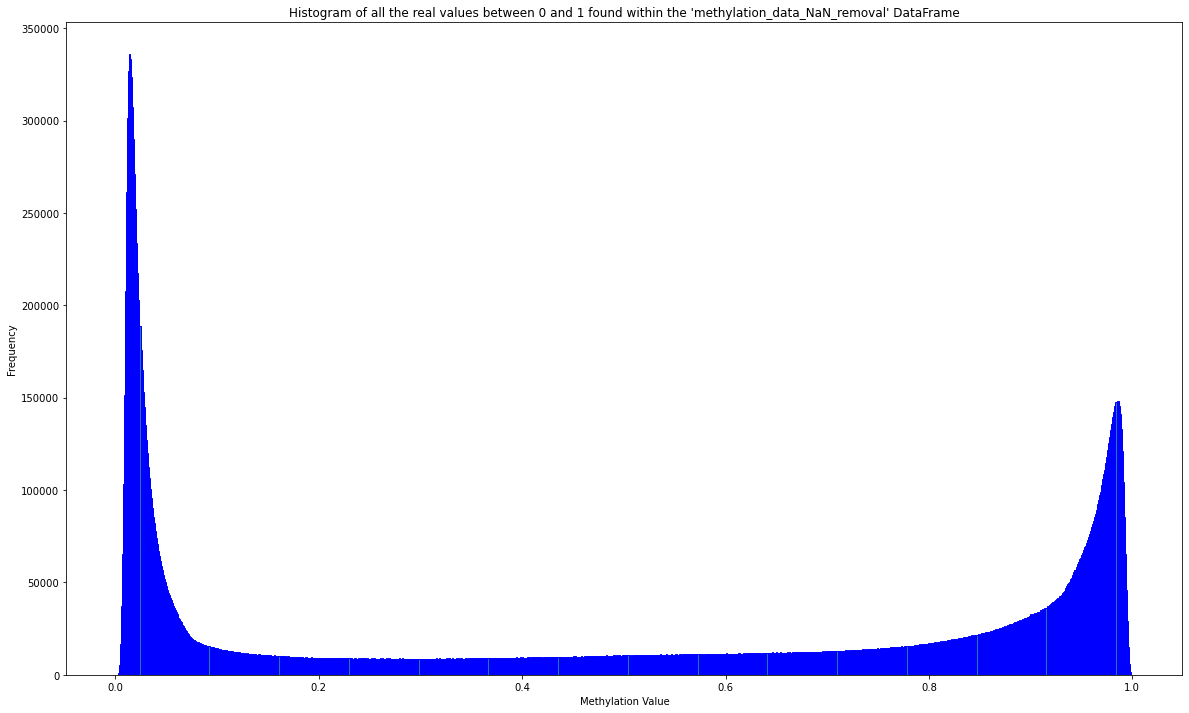

In [46]:
plt.figure(figsize=(20, 12))

# flattening the 'methylation_data_NaN_removal' DataFrame into a 1D array.
methylation_data_NaN_removal_values = np.ravel(methylation_data_NaN_removal.iloc[:, 1:].values)

# Plotting the histogram of all values.
plt.hist(methylation_data_NaN_removal_values, bins=1000, edgecolor='blue')
plt.title('Histogram of all the real values between 0 and 1 found within the \'methylation_data_NaN_removal\' DataFrame')
plt.xlabel('Methylation Value')
plt.ylabel('Frequency')
plt.show()

As we can see from the histogram above, there are two clear peaks. The first one is quite close to 0 and the second one is quite close to 1. Since we expect most of the values to be either close to 0 or close to 1 and not somewhere around 0.5 (although these are possible and also occur in the histogram above, but occur way less often), these two peaks make sense. Something we can observe, however, is that the peak closer to 0 is a little bit higher than the peak closer to 1 and there exist quite a lot of values that are really close to 0 (in contrast to the smaller peak of values that are really close to 1). This could be caused by there simply existing more CpG sites within the dataset which are not methylated. Although it is not true that these CpG sites are completely not methylated, as then the value would be 0, I refer to them as being classified as not methylated as most of the cells are not methylated for that site which also makes using the notation a bit easier. Another possible reason why the peak closer to 0 is higher could be because some samples are outliers and have measurement data that are likely to be incorrect by only containing zeros for example. To investigate whether there exist samples that could potentially be classified as outliers, all of the distributions can be plotted of the samples independently and displayed within the same plot. This allows us to compare the distribution of methylation values for a single sample with all the other distributions of the other samples directly and conclude, visually, whether any outliers appear. To achieve this, the function 'sns.kdeplot()' can be called for every sample (patient) which plots a Kernel Density Estimate of the values present in its column. Now this will create a lot of different kernel density estimates (65 in total) within the same plot, so this plot is not really meant for detecting which distribution corresponds to which sample but rather whether a distribution appears that does not look similar to the other ones.

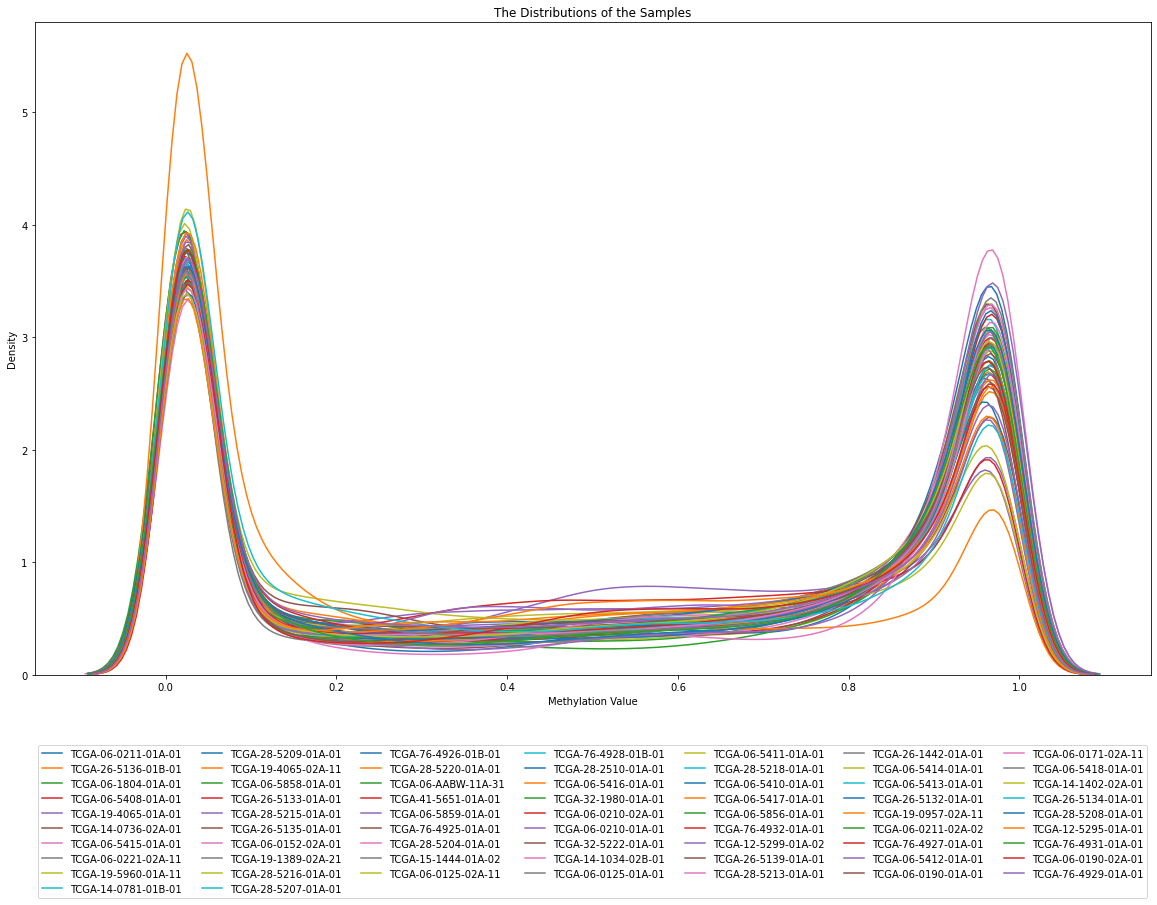

In [47]:
plt.figure(figsize=(20, 12))

# For every column (except for the column featuring the names of the CpG sites) in the 'methylation_data_NaN_removal'
# DataFrame, the kernel density estimate of the values is plotted.
for col in methylation_data_NaN_removal.columns:
    if col != 'CpG sites':
        sns.kdeplot(data=methylation_data_NaN_removal, x=col, label=col)

# Adding the legend, a title and the labels to the plot.
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=7)
plt.title("The Distributions of the Samples")
plt.xlabel("Methylation Value")
plt.ylabel("Density")

# Showing the plot.
plt.show()

In addition to displaying the distributions of the samples all within the same plot, we can also display the distribution of each sample in a different plot, creating in total 65 subplots. This is achieved in the code below by calling the function 'plt.subplots()' and then adding each kde plot to a separate subplot.

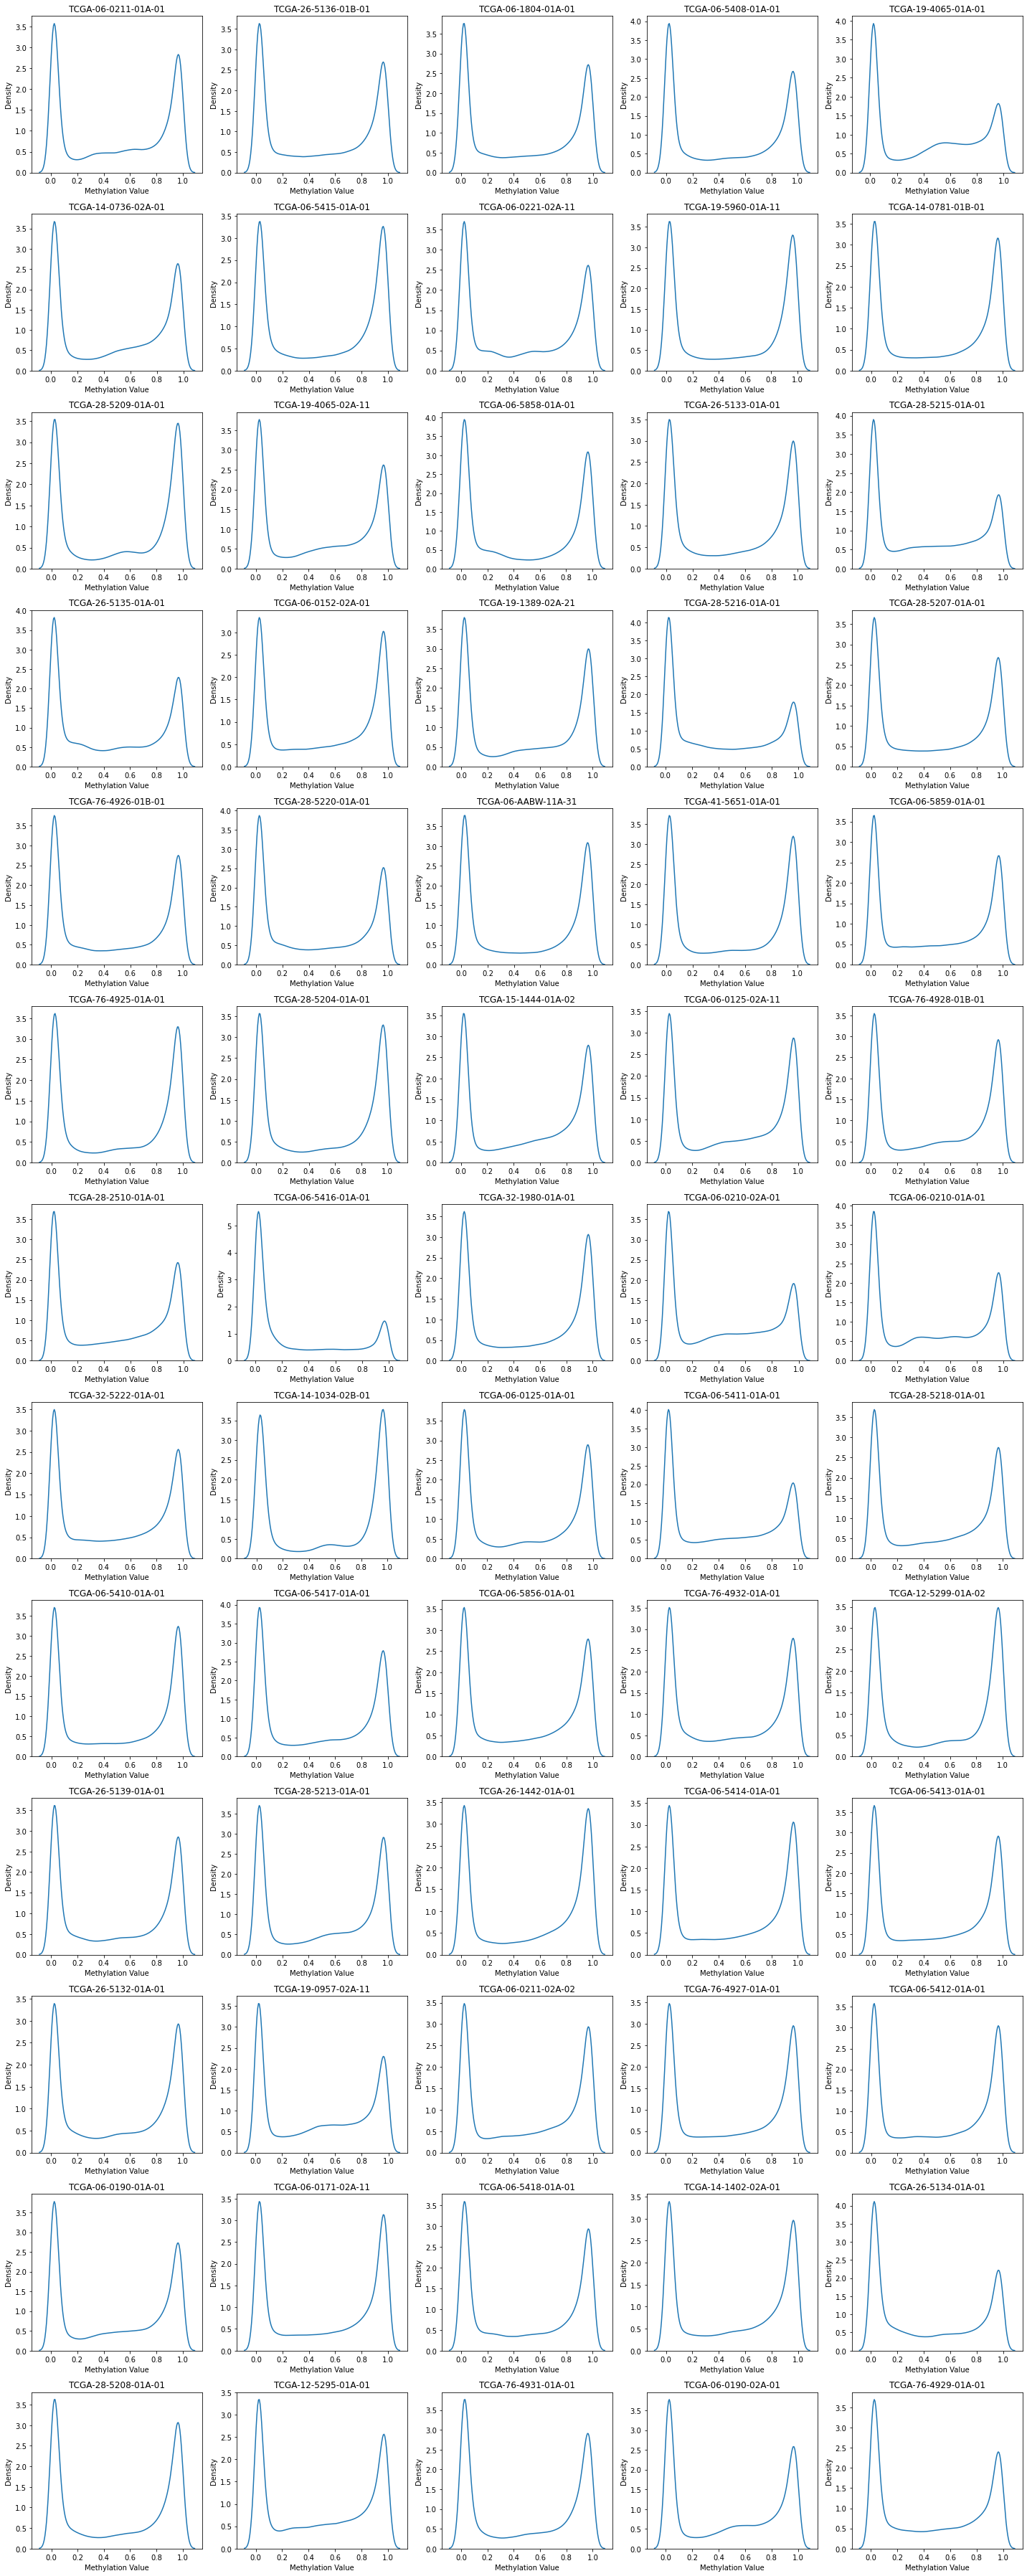

In [48]:
fig, axes = plt.subplots(nrows=13, ncols=5, figsize=(20, 50))
axes = axes.flatten()

# For every column (except for the column featuring the names of the CpG sites) in the 'methylation_data_NaN_removal'
# DataFrame, the kernel density estimate of the values is plotted.
for i, col in enumerate(methylation_data_NaN_removal.columns):
    if col != 'CpG sites':
        sns.kdeplot(data=methylation_data_NaN_removal, x=col, label=col, ax=axes[i-1])
        
        # Adding a title and the labels to the plot.
        axes[i-1].set_xlabel("Methylation Value")
        axes[i-1].set_ylabel("Density")
        axes[i-1].set_title(col)

# Showing the plot.
plt.tight_layout()
plt.show()

As we can see from the plot featuring all the distributions above, all the distributions from the 65 samples look really similar having two distinct peaks. The first one is quite close to 0 and the second one is quite close to 1. We can identify some distributions that have a slightly higher density for the peak containing values closer to 0 and a slighlty lower density for the peak containing values closer to 1 (and vice versa) by looking at both this plot and also the subplots above. A good example of a sample where there is quite in difference in the heights of the peaks would be the sample with case id TCGA-06-5416-01A-01 present in one of the subplots. Although samples with such distributions exist, there is no sample with a distribution that looks completely different from the other ones. Therefore, we cannot conclude that there exist any samples within the dataset that would be classified as outliers and the reason for the peak close to 0 being higher than the peak close to 1 is most likely that there simply exist more CpG sites within the dataset which are not methylated (have a value close to 0).

Another way to identify which samples could be potentially classified as outliers and thus can be removed from our dataset is to perform a Principal Component Analysis (PCA). PCA is a statistical method used to reduce the dimensionality of a dataset while retaining as much of the original variation as possible [2]. In the context of outlier detection, PCA can be used to identify samples that are far away from the main cluster of samples in the dataset and thus can potentially be removed from the dataset. The PCA algorithm works by finding the directions called the principal components in the data that explain the most variation forming a new coordinate system that describes the data in terms of these directions. The first principal component is then the direction that explains the most variation in the data, the second principal component is the direction that explains the most variation after having considered the first principal component, and so on. 

In the code block below, PCA is applied to the 'methylation_data_NaN_removal' DataFrame. To achieve this, the PCA library from sklearn.decomposition can be used which is imported in the beginning of this notebook. The procedure can be divided into the following 3 steps:
1. Standardizing the data such that each column has zero mean and unit variance by subtracting the mean and dividing by the standard deviation to ensure that all the variables have the same scale and variance. Even though our data is already scaled to be between 0 and 1, this standardization is still performed as a statistical method like PCA is sensitive to the scale of the variables.
2. To describe how each variable is related to every other variable, PCA computes the covariance matrix of the standardized data. The eigenvalues and eigenvectors of the covariance matrix are then computed where the eigenvectors represent the principal components and the corresponding eigenvalues the amount of variation explained by each principal component. This can be achieved by calling the function 'fit' on the PCA model.
3. We can visualize the data in a lower-dimensional space by projecting the data onto the first few principal components allowing us to detect patterns and relationships in the data. To achieve this, the function 'transform' can be called which computes the scores which are then plotted to represent this lower-dimensional space. Visually, a sample that is far away from the main cluster of samples in the plot could potentially be considered to be an outlier.

In [49]:
# Transposing the data such that the samples appear as rows and not as columns as this is what the PCA library assumes.
methylation_data_T = methylation_data_NaN_removal.T.iloc[1:,:]

# Step 1: Standardizing the data such that each column has zero mean and unit variance by subtracting the mean and dividing 
# by the standard deviation to ensure that all the variables have the same scale and variance.
methylation_data_standardized = (methylation_data_T - methylation_data_T.mean()) / methylation_data_T.std()
print('The standardized methylation data:')
methylation_data_standardized

The standardized methylation data:


0         1         2         3         4       \
TCGA-06-0211-01A-01 -0.909575 -0.023562  1.352381  -0.16475 -0.711291   
TCGA-26-5136-01B-01 -0.049673 -0.181609  0.147137  0.315621 -0.276898   
TCGA-06-1804-01A-01 -0.071231  -0.19078  0.313035  0.308297 -0.643217   
TCGA-06-5408-01A-01 -0.259596 -0.527058 -0.146024  0.086513 -0.734646   
TCGA-19-4065-01A-01 -1.999688 -0.543965 -3.229158 -0.646663 -1.907216   
...                       ...       ...       ...       ...       ...   
TCGA-28-5208-01A-01  1.086997  0.864769  1.002468  0.429823  1.776391   
TCGA-12-5295-01A-01 -0.483198   0.42986   0.00637  -0.06972 -2.006149   
TCGA-76-4931-01A-01  0.032677  -0.15455 -0.508247  0.394565  -0.55169   
TCGA-06-0190-02A-01 -0.790296 -0.594636 -0.589888 -1.436561  -0.52399   
TCGA-76-4929-01A-01   -0.6139  1.582792  0.053328 -0.065808 -0.297875   

                       5         6         7         8         9       ...  \
TCGA-06-0211-01A-01  1.075163 -0.670295  0.488585  0.626811 -0.687057  ...   
TCGA-26-5136-01B-01 -0.208919   1.95349 -0.594047 -0.262253  0.656917  ...   
TCGA-06-1804-01A-01  0.657457  0.265015 -0.830301  0.420131  2.213699  ...   
TCGA-06-5408-01A-01 -0.198832  1.855357 -0.794449 -0.511656  0.288806  ...   
TCGA-19-4065-01A-01  0.276892 -0.669655 -3.807983 -3.350631 -0.694239  ...   
...                       ...       ...       ...       ...       ...  ...   
TCGA-28-5208-01A-01   -1.1829 -0.682267  0.689338 -0.843554  2.109009  ...   
TCGA-12-5295-01A-01  0.520069  2.017349 -0.622203  0.556536  2.047089  ...   
TCGA-76-4931-01A-01 -0.201016     0.217 -0.068229  -0.31857  0.231845  ...   
TCGA-06-0190-02A-01 -1.207623 -0.672467  0.316509  0.699095 -0.666435  ...   
TCGA-76-4929-01A-01  0.444545  2.139618  -0.69895  0.262442 -0.005127  ...   

                       381254    381255    381256    381257    381258  \
TCGA-06-0211-01A-01  0.608155 -0.495051 -0.919635    0.1994 -0.833628   
TCGA-26-5136-01B-01   0.00249  0.468169 -0.649259 -0.142615  0.195093   
TCGA-06-1804-01A-01  0.846292 -0.827073  0.610357  -0.33082  1.556384   
TCGA-06-5408-01A-01 -0.762996   1.33372  1.043911   0.04563  0.142878   
TCGA-19-4065-01A-01 -0.504623 -0.571892 -2.000723  0.357565 -1.023305   
...                       ...       ...       ...       ...       ...   
TCGA-28-5208-01A-01  2.229171  1.122061 -0.147069  0.590111  1.015055   
TCGA-12-5295-01A-01  0.631161  1.253973  0.192595  -0.40172  0.626349   
TCGA-76-4931-01A-01 -0.925783 -0.818671  1.781145 -0.192994  0.091322   
TCGA-06-0190-02A-01 -0.403785 -0.438762 -1.637126 -0.827502 -0.933548   
TCGA-76-4929-01A-01  1.795288  1.879149  0.423634  0.256621  1.408051   

                       381259    381260    381261    381262    381263  
TCGA-06-0211-01A-01 -0.897267 -0.025953 -0.218316 -0.251303  0.064598  
TCGA-26-5136-01B-01  1.964372 -0.261065   0.43266 -0.234245  2.025393  
TCGA-06-1804-01A-01  3.336942  0.568102  1.212019  0.099248  0.204371  
TCGA-06-5408-01A-01 -0.556828 -0.474072  0.041964 -0.271104  0.112306  
TCGA-19-4065-01A-01 -0.932245  2.443783 -0.807237  2.169054 -0.724928  
...                       ...       ...       ...       ...       ...  
TCGA-28-5208-01A-01  1.327231  -0.40541   0.80248 -0.086519   2.09359  
TCGA-12-5295-01A-01  0.001025 -0.579971  0.657349 -0.464807  0.821192  
TCGA-76-4931-01A-01 -0.435718 -0.508483  1.345996 -0.416717 -0.546702  
TCGA-06-0190-02A-01 -0.889927 -0.414365 -0.955513 -0.585568 -1.185943  
TCGA-76-4929-01A-01  2.326415 -0.528814  1.801364 -0.257126  1.409186  

[65 rows x 381264 columns]

In [50]:
# Step 2: To describe how each variable is related to every other variable, PCA computes the principal components of the 
# standardized data. This can be achieved by calling the function 'fit' on the PCA model.
pca = PCA()
pca.fit(methylation_data_standardized)

PCA()

In [52]:
# Step 3: Visualizing the data in a lower-dimensional space by projecting the data onto the first few principal components 
# allowing us to detect patterns and relationships in the data. To achieve this, the function 'transform' can be called 
# which computes the scores which are then plotted to represent this lower-dimensional space.
scores = pca.transform(methylation_data_standardized)

indices = methylation_data_standardized.index
labels = []
for i in range(len(indices)):
    if indices[i] == "TCGA-06-5416-01A-01":
        labels.append(indices[i])
    else:
        labels.append("")
        
    
fig = px.scatter(x=scores[:, 0], y=scores[:, 1], text=labels, labels={"x": "PC1", "y": "PC2"})
fig.update_layout(title={'text': 'PCA scores plot of the methylation data', 'x':0.5},
                  xaxis_title='PC1',
                  yaxis_title='PC2')
fig.update_traces(textposition='bottom left')
fig.show()

Each point in the scores plot above represents a sample, and the position of the point is determined by the values of the first two principal components. Samples, data points, that are close together in the plot have similar principal component scores and therefore similar methylation profiles. Conversely, samples that are far apart have different methylation profiles. Samples that are located in different regions of the plot may represent different subpopulations or groups within the dataset. Outliers in the PCA scores plot may represent samples that have unusual methylation profiles compared to the rest of the dataset. These outliers may be due to technical or biological factors that need to be identified and addressed. Within the scores plot above, I already denoted some potential outliers with their sample names such that it is easier to refer to them in the paragraph below.

As we can see from the scores plot above, there is one data point that is quite far away from the main cluster of data points. This data point is denoted by its sample name 'TCGA-06-5416-01A-01' in the scores plot above. This is also the sample in the plot where the distributions of all the samples are displayed which was represented by the orange line and was considered to be a potential outlier. Since this is located so far away from the main cluster indicating that it has unique patterns of variation that are not well-explained by the principal components, I have decided to remove this sample from my dataset. This is done in the code below. 

In [53]:
methylation_data_NaN_sample_removal = methylation_data_NaN_removal.drop('TCGA-06-5416-01A-01', axis=1)
print("The new 'methylation_data_NaN_sample_removal' DataFrame after removing the sample with the case id 'TCGA-06-5416-01A-01':")
methylation_data_NaN_sample_removal

The new 'methylation_data_NaN_sample_removal' DataFrame after removing the sample with the case id 'TCGA-06-5416-01A-01':


CpG sites  TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  \
0            cg00050873             0.598401             0.696228   
1            cg00212031             0.148621             0.116158   
2            cg00213748             0.836599             0.637830   
3            cg00214611             0.032786             0.034901   
4            cg00455876             0.642416             0.693596   
...                 ...                  ...                  ...   
381259    ch.22.772318F             0.032142             0.143433   
381260  ch.22.43177094F             0.009543             0.006878   
381261    ch.22.909671F             0.111719             0.155722   
381262  ch.22.46830341F             0.010343             0.010581   
381263   ch.22.1008279F             0.015390             0.025336   

        TCGA-06-1804-01A-01  TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  \
0                  0.693775             0.672346             0.474384   
1                  0.114274             0.045200             0.041728   
2                  0.665190             0.589482             0.081013   
3                  0.034869             0.033892             0.030664   
4                  0.650437             0.639665             0.501514   
...                     ...                  ...                  ...   
381259             0.196813             0.045382             0.030782   
381260             0.016276             0.004464             0.037535   
381261             0.208404             0.129313             0.071910   
381262             0.015248             0.010066             0.044211   
381263             0.016099             0.015632             0.011385   

        TCGA-14-0736-02A-01  TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  \
0                  0.695819             0.844931             0.616233   
1                  0.034927             0.033947             0.035452   
2                  0.607042             0.748129             0.632638   
3                  0.032111             0.037053             0.029939   
4                  0.758325             0.783247             0.664261   
...                     ...                  ...                  ...   
381259             0.052378             0.086724             0.061200   
381260             0.043951             0.007839             0.037672   
381261             0.109692             0.181898             0.111550   
381262             0.034146             0.010077             0.035975   
381263             0.016199             0.015469             0.014453   

        TCGA-19-5960-01A-11  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
0                  0.472024  ...             0.758095             0.872146   
1                  0.019626  ...             0.026595             0.036259   
2                  0.339565  ...             0.564641             0.846239   
3                  0.024187  ...             0.029693             0.025648   
4                  0.900718  ...             0.671254             0.814129   
...                     ...  ...                  ...                  ...   
381259             0.117800  ...             0.033715             0.024192   
381260             0.006655  ...             0.009374             0.014761   
381261             0.103455  ...             0.060410             0.048582   
381262             0.014086  ...             0.006724             0.014002   
381263             0.012466  ...             0.012878             0.009071   

        TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
0                  0.681442             0.797791             0.785146   
1                  0.218612             0.172446             0.031262   
2                  0.580089             0.726151             0.893503   
3                  0.033634             0.032743             0.037687   
4                  0.700934             0.454763             0.830252   
...                     ...                  ...        

Since the samples of the methylation data and the gene expression data need to match, this sample will also be deleted from the gene expression data within the notebook 'Checking Resulting Methylation Data and Gene Expression Data File.ipynb'.

Now after having decided which of the samples are classified to be outliers, we can use the generated plots above to determine the thresholds to denote whether a value is close enough to 0 or close enough to 1 which allows us to investigate whether a CpG site is always methylated or never methylated. These CpG sites can then be removed from the dataset. Looking at the plots above, especially the one containing the distributions of all the samples where the peaks end, we can set the thresholds to be 0.15 and 0.85 meaning that a CpG site is considered to be never methylated when all of the values are equal to or lower than 0.15 and a CpG site is considered to be always methylated when all of the values are equal to or higher than 0.85. To remove these always or never methylated CpG sites we can construct masks that check whether every value present for the current CpG site is either lower or higher than the given thresholds.

In [54]:
# Creating a copy of the 'methylation_data_NaN_sample_removal' DataFrame to store the computations performed (such that the 
# original DataFrame is left unaltered).
methylation_data_NaN_sample_removal_copy = methylation_data_NaN_sample_removal.copy()

# Creating the two masks.
low_mask = (methylation_data_NaN_sample_removal_copy.iloc[:, 1:] <= 0.15).all(axis=1)
high_mask = (methylation_data_NaN_sample_removal_copy.iloc[:, 1:] >= 0.85).all(axis=1)

# Retrieving the CpG sites which are the CpG sites present in the masks.
methylation_data_cleaned = methylation_data_NaN_sample_removal_copy[~(low_mask | high_mask)]

# Retrieving the CpG sites which are only the CpG sites present in the masks.
never_methylated = methylation_data_NaN_sample_removal_copy[(low_mask)]
always_methylated = methylation_data_NaN_sample_removal_copy[(high_mask)]

# In addition, we can also reset the index of the 'methylation_data_cleaned' DataFrame by calling the function 
# 'reset_index()'.
methylation_data_cleaned.reset_index(drop=True, inplace=True)

Now we can display both the 'never_methylated' and 'always_methylated' DataFrames which respectively contain the CpG sites that are never methylated and the CpG sites that are always methylated.

In [55]:
print("The 'never_methylated' DataFrame which contains the CpG sites that are never methylated:")
never_methylated

The 'never_methylated' DataFrame which contains the CpG sites that are never methylated:


CpG sites  TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  \
3            cg00214611             0.032786             0.034901   
12           cg02842889             0.024280             0.027225   
17           cg03683899             0.022643             0.026167   
30           cg04840163             0.069138             0.063490   
51           cg10213302             0.048498             0.070223   
...                 ...                  ...                  ...   
381257    ch.22.740407F             0.017298             0.014690   
381258    ch.22.757911F             0.022103             0.043642   
381260  ch.22.43177094F             0.009543             0.006878   
381262  ch.22.46830341F             0.010343             0.010581   
381263   ch.22.1008279F             0.015390             0.025336   

        TCGA-06-1804-01A-01  TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  \
3                  0.034869             0.033892             0.030664   
12                 0.027385             0.026198             0.025281   
17                 0.026426             0.025895             0.028280   
30                 0.057030             0.063788             0.053017   
51                 0.071335             0.066993             0.064365   
...                     ...                  ...                  ...   
381257             0.013254             0.016126             0.018505   
381258             0.072143             0.042548             0.018132   
381260             0.016276             0.004464             0.037535   
381262             0.015248             0.010066             0.044211   
381263             0.016099             0.015632             0.011385   

        TCGA-14-0736-02A-01  TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  \
3                  0.032111             0.037053             0.029939   
12                 0.027206             0.030617             0.023459   
17                 0.026724             0.028763             0.023706   
30                 0.090687             0.081633             0.048538   
51                 0.059713             0.074015             0.065716   
...                     ...                  ...                  ...   
381257             0.029466             0.011896             0.014477   
381258             0.037516             0.037702             0.037085   
381260             0.043951             0.007839             0.037672   
381262             0.034146             0.010077             0.035975   
381263             0.016199             0.015469             0.014453   

        TCGA-19-5960-01A-11  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
3                  0.024187  ...             0.029693             0.025648   
12                 0.021333  ...             0.023358             0.024013   
17                 0.020053  ...             0.025528             0.026593   
30                 0.049244  ...             0.060052             0.049043   
51                 0.058506  ...             0.055138             0.050833   
...                     ...  ...                  ...                  ...   
381257             0.015716  ...             0.013696             0.012407   
381258             0.084058  ...             0.019164             0.016521   
381260             0.006655  ...             0.009374             0.014761   
381262             0.014086  ...             0.006724             0.014002   
381263             0.012466  ...             0.012878             0.009071   

        TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
3                  0.033634             0.032743             0.037687   
12                 0.026424             0.027795             0.028153   
17                 0.025451             0.026117             0.034498   
30                 0.061261             0.058610             0.057897   
51                 0.065695             0.065508             0.055698   
...                     ...                  ...        

In [56]:
print("The 'always_methylated' DataFrame which contains the CpG sites that are always methylated:")
always_methylated

The 'always_methylated' DataFrame which contains the CpG sites that are always methylated:


CpG sites  TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  \
102     cg00021786             0.985275             0.990859   
181     cg00907920             0.942206             0.955380   
337     cg02540297             0.960844             0.978459   
384     cg02973417             0.963045             0.973136   
564     cg04702079             0.978393             0.953888   
...            ...                  ...                  ...   
381177  cg27381549             0.966349             0.957502   
381181  cg27436324             0.990384             0.986811   
381197  cg27512565             0.990425             0.972067   
381202  cg27528247             0.954020             0.957070   
381219  cg27656573             0.974019             0.955336   

        TCGA-06-1804-01A-01  TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  \
102                0.992305             0.991666             0.986221   
181                0.967450             0.972334             0.966411   
337                0.979620             0.960936             0.927031   
384                0.976595             0.972235             0.973934   
564                0.982066             0.984038             0.970522   
...                     ...                  ...                  ...   
381177             0.977825             0.978958             0.921960   
381181             0.970504             0.982026             0.985338   
381197             0.955870             0.970100             0.966648   
381202             0.985914             0.968419             0.896812   
381219             0.988785             0.987671             0.980038   

        TCGA-14-0736-02A-01  TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  \
102                0.984001             0.990884             0.988569   
181                0.931858             0.920639             0.960933   
337                0.972453             0.984831             0.946870   
384                0.963556             0.958724             0.972647   
564                0.982350             0.963854             0.981721   
...                     ...                  ...                  ...   
381177             0.895485             0.956641             0.916347   
381181             0.985140             0.988926             0.990933   
381197             0.990773             0.982666             0.993767   
381202             0.950177             0.951339             0.958746   
381219             0.982569             0.986662             0.992012   

        TCGA-19-5960-01A-11  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
102                0.991514  ...             0.986734             0.989635   
181                0.955670  ...             0.925824             0.955445   
337                0.942995  ...             0.942509             0.963888   
384                0.970404  ...             0.959791             0.969892   
564                0.978649  ...             0.978276             0.979771   
...                     ...  ...                  ...                  ...   
381177             0.972510  ...             0.948325             0.905291   
381181             0.974441  ...             0.988673             0.989554   
381197             0.961820  ...             0.988426             0.991255   
381202             0.974927  ...             0.934967             0.943584   
381219             0.969220  ...             0.951334             0.972292   

        TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
102                0.990496             0.990181             0.989374   
181                0.936586             0.967754             0.926714   
337                0.984104             0.979553             0.959316   
384                0.963924             0.980802             0.942754   
564                0.962305             0.982660             0.952352   
...                     ...                  ...                  ...   
381177             0.993666           

Discarding these never methylated and always methylated sites from the 'methylation_data_NaN_removal_copy' DataFrame results in the final cleaned methylation DataFrame called 'methylation_data_cleaned'.

In [57]:
print("The final cleaned methylation DataFrame called 'methylation_data_cleaned':")
methylation_data_cleaned

The final cleaned methylation DataFrame called 'methylation_data_cleaned':


CpG sites  TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  \
0          cg00050873             0.598401             0.696228   
1          cg00212031             0.148621             0.116158   
2          cg00213748             0.836599             0.637830   
3          cg00455876             0.642416             0.693596   
4          cg01707559             0.671818             0.312592   
...               ...                  ...                  ...   
280995  ch.22.707049R             0.023967             0.093547   
280996  ch.22.728807R             0.074757             0.103989   
280997  ch.22.734399R             0.205177             0.220414   
280998  ch.22.772318F             0.032142             0.143433   
280999  ch.22.909671F             0.111719             0.155722   

        TCGA-06-1804-01A-01  TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  \
0                  0.693775             0.672346             0.474384   
1                  0.114274             0.045200             0.041728   
2                  0.665190             0.589482             0.081013   
3                  0.650437             0.639665             0.501514   
4                  0.554964             0.315414             0.448499   
...                     ...                  ...                  ...   
280995             0.091928             0.042238             0.030906   
280996             0.064681             0.130256             0.072425   
280997             0.291399             0.315832             0.144253   
280998             0.196813             0.045382             0.030782   
280999             0.208404             0.129313             0.071910   

        TCGA-14-0736-02A-01  TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  \
0                  0.695819             0.844931             0.616233   
1                  0.034927             0.033947             0.035452   
2                  0.607042             0.748129             0.632638   
3                  0.758325             0.783247             0.664261   
4                  0.028153             0.051755             0.030808   
...                     ...                  ...                  ...   
280995             0.042918             0.077318             0.057004   
280996             0.093775             0.078673             0.108003   
280997             0.206865             0.297240             0.270165   
280998             0.052378             0.086724             0.061200   
280999             0.109692             0.181898             0.111550   

        TCGA-19-5960-01A-11  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
0                  0.472024  ...             0.758095             0.872146   
1                  0.019626  ...             0.026595             0.036259   
2                  0.339565  ...             0.564641             0.846239   
3                  0.900718  ...             0.671254             0.814129   
4                  0.023221  ...             0.026048             0.504077   
...                     ...  ...                  ...                  ...   
280995             0.090479  ...             0.023218             0.030588   
280996             0.152517  ...             0.069550             0.084550   
280997             0.303982  ...             0.169489             0.123179   
280998             0.117800  ...             0.033715             0.024192   
280999             0.103455  ...             0.060410             0.048582   

        TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
0                  0.681442             0.797791             0.785146   
1                  0.218612             0.172446             0.031262   
2                  0.580089             0.726151             0.893503   
3                  0.700934             0.454763             0.830252   
4                  0.377020             0.551934             0.039638   
...                     ...                  ...                  ...   
28099

As we can see from the output above, we are left with 281,000 CpG sites. To verify that no missing values have been added throughout the process of removing never methylated and always methylated sites, we can call the function 'isna()' again.

In [58]:
# Checking whether all the CpG sites in the 'methylation_data_cleaned' DataFrame do indeed not contain any missing
# values. This can be achieved by calling the function 'isna()' followed by calling the function 'any()' twice. The reason
# for having a double 'any()' call in the code is to check if there are any True values in the boolean DataFrame that is 
# returned by the 'isna()' function.
if not methylation_data_cleaned.isna().any().any():
    print("Every value in the 'methylation_data_cleaned' DataFrame is not NaN.")
else:
    print("There are NaN values in the 'methylation_data_cleaned' DataFrame.")

Every value in the 'methylation_data_cleaned' DataFrame is not NaN.


To make the data slighlty more normally distributed, we could apply a transformation which converts the beta values to M-values. The beta values are the values present in the 'methylation_data_cleaned' DataFrame. However, the beta values are heteroscedastic, meaning they have different variances at different levels of methylation, with lower variance at extreme values of 0 or 1. The transformation to M-values addresses this issue as the M-values have more uniform variance across all levels of methylation [3]. The formula for converting beta values to M-values is: M = log2(ß / (1 - ß)), where M is the transformed value and log2 is the base-2 logarithm. 

One reason why this transformation is applied is that the resulting (more) normally distributed data follows the assumptions of most statistical tests. Another reason is that it can make differences between data points easier to interpret, especially when the data has a wide range of values. Both the non-transformed and the transformed data will be stored in separate files in the section 'Storing the Resulting Cleaned Methylation data' such that both can be used when applying the machine learning algorithms later on. 

In [59]:
# Copying the 'methylation_data_cleaned' DataFrame such that is not altered.
methylation_data_copy = methylation_data_cleaned.copy()

# Applying transformation where the beta values are transformed to M-values.
methylation_data_M_transformed = np.log2(methylation_data_copy.iloc[:,1:] / (1-methylation_data_copy.iloc[:,1:]))

print("The M transformed cleaned methylation data:")
methylation_data_M_transformed

The M transformed cleaned methylation data:


TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  TCGA-06-1804-01A-01  \
0                  0.575358             1.196570             1.179877   
1                 -2.518160            -2.927707            -2.954364   
2                  2.356115             0.816507             0.990424   
3                  0.845228             1.178662             0.895856   
4                  1.033575            -1.136884             0.318470   
...                     ...                  ...                  ...   
280995            -5.347784            -3.276470            -3.304231   
280996            -3.629545            -3.107092            -3.854037   
280997            -1.953764            -1.822492            -1.281976   
280998            -4.912269            -2.578194            -2.028914   
280999            -2.991143            -2.438740            -1.925380   

        TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  TCGA-14-0736-02A-01  \
0                  1.037031            -0.147951             1.193780   
1                 -4.400794            -4.521361            -4.788215   
2                  0.522004            -3.503816             0.627419   
3                  0.827976             0.008734             1.649747   
4                 -1.117984            -0.298258            -5.109380   
...                     ...                  ...                  ...   
280995            -4.503067            -4.970658            -4.478993   
280996            -2.739243            -3.678896            -3.272591   
280997            -1.115193            -2.568587            -1.938879   
280998            -4.394741            -4.976683            -4.177285   
280999            -2.751289            -3.689998            -3.020847   

        TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  TCGA-19-5960-01A-11  \
0                  2.445926             0.683243            -0.161612   
1                 -4.830728            -4.765906            -5.642500   
2                  1.570600             0.784178            -0.959728   
3                  1.853414             0.984410             3.181472   
4                 -4.195476            -4.975419            -5.394501   
...                     ...                  ...                  ...   
280995            -3.576952            -4.048114            -3.329448   
280996            -3.549764            -3.045972            -2.474210   
280997            -1.241406            -1.433729            -1.195136   
280998            -3.396540            -3.939215            -2.904770   
280999            -2.169153            -2.993604            -3.115365   

        TCGA-14-0781-01B-01  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
0                  2.945788  ...             1.647939             2.770073   
1                 -4.581261  ...            -5.193802            -4.732231   
2                  0.549859  ...             0.375128             2.460377   
3                  1.227676  ...             1.029885             2.130957   
4                 -3.237433  ...            -5.224614             0.023525   
...                     ...  ...                  ...                  ...   
280995            -3.982111  ...            -5.394690            -4.986055   
280996            -3.735985  ...            -3.741805            -3.436608   
280997            -2.005095  ...            -2.292808            -2.831527   
280998            -4.023309  ...            -4.840999            -5.334004   
280999            -3.205459  ...            -3.959180            -4.291577   

        TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
0                  1.097036             1.980160             1.869605   
1                 -1.837664            -2.262707            -4.953635   
2                  0.466191             1.406889             3.068663   
3                  1.228815            -0.261768             2.290150   
4                 -0.724543             0.300784            -4.598641   
..

We can also plot the transformed distributions of methylation values for each of the samples independently but within the same plot to further investigate the distributions. To achieve this, the function 'sns.kdeplot()' can be called for every sample (patient) which plots a Kernel Density Estimate of the values present in its column. Now this will create a lot of different kernel density estimates (64 in total) within the same plot, so this plot is not really meant for detecting which distribution corresponds to which sample but rather whether a distribution appears that does not look similar to the other ones.

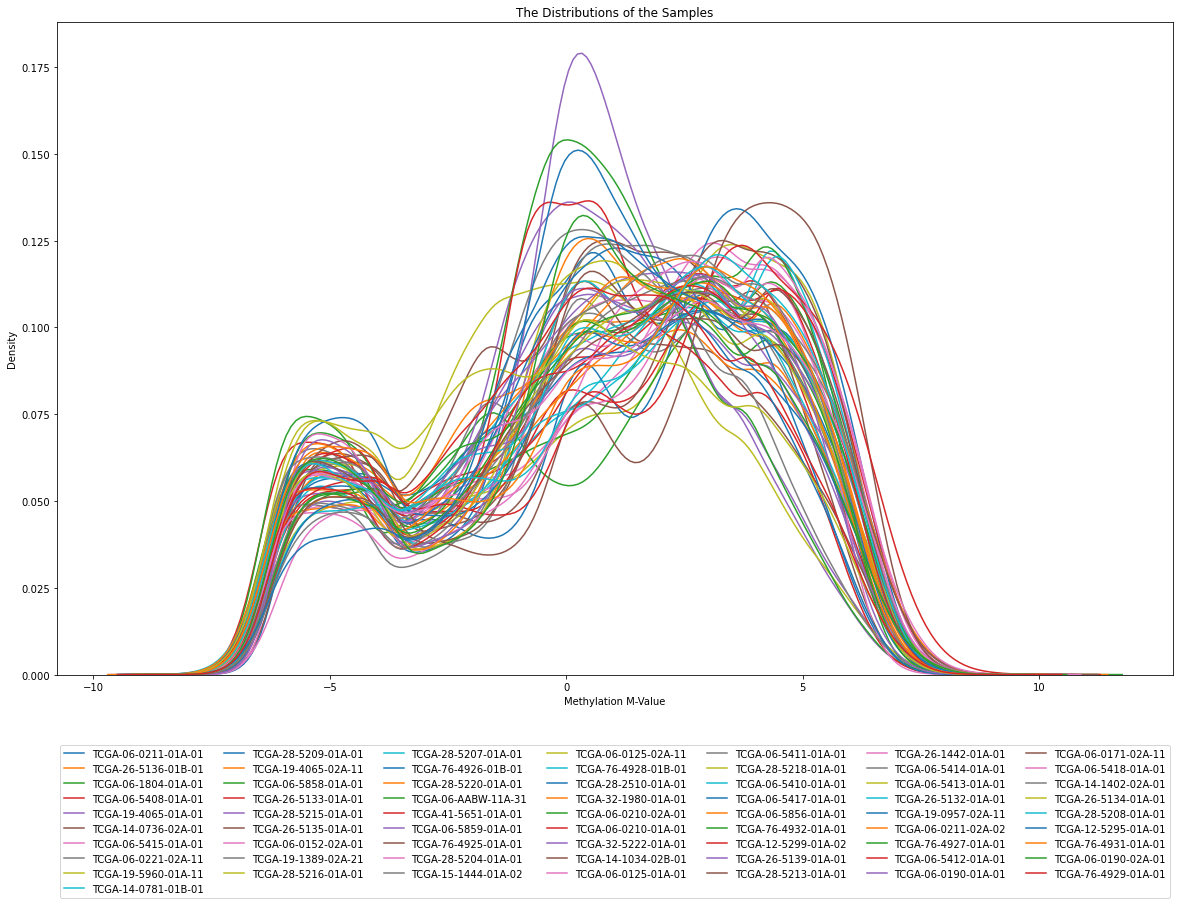

In [60]:
plt.figure(figsize=(20, 12))

# For every column (except for the column featuring the names of the genes) in the 'methylation_data_M_transformed' 
# DataFrame, the kernel density estimate of the values is plotted.
for col in methylation_data_M_transformed.columns:
    sns.kdeplot(data=methylation_data_M_transformed, x=col, label=col)

# Adding the legend, a title and the labels to the plot.
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=7)
plt.title("The Distributions of the Samples")
plt.xlabel("Methylation M-Value")
plt.ylabel("Density")

# Showing the plot.
plt.show()

As we can see from the plot above, all of the distributions now look somewhat normally distributed but it appears that there are multiple modes.

Next, we can include the column featuring the names of the CpG sites in the 'methylation_data_M_transformed' DataFrame by calling the function 'pd.concat()'.

In [61]:
# Inserting the column featuring the names of the CpG sites into the 'methylation_data_M_transformed' DataFrame.
methylation_data_M_cleaned_transformed = pd.concat([methylation_data_cleaned['CpG sites'], methylation_data_M_transformed], axis=1)

print("The M transformed cleaned methylation data:")
methylation_data_M_cleaned_transformed

The M transformed cleaned methylation data:


CpG sites  TCGA-06-0211-01A-01  TCGA-26-5136-01B-01  \
0          cg00050873             0.575358             1.196570   
1          cg00212031            -2.518160            -2.927707   
2          cg00213748             2.356115             0.816507   
3          cg00455876             0.845228             1.178662   
4          cg01707559             1.033575            -1.136884   
...               ...                  ...                  ...   
280995  ch.22.707049R            -5.347784            -3.276470   
280996  ch.22.728807R            -3.629545            -3.107092   
280997  ch.22.734399R            -1.953764            -1.822492   
280998  ch.22.772318F            -4.912269            -2.578194   
280999  ch.22.909671F            -2.991143            -2.438740   

        TCGA-06-1804-01A-01  TCGA-06-5408-01A-01  TCGA-19-4065-01A-01  \
0                  1.179877             1.037031            -0.147951   
1                 -2.954364            -4.400794            -4.521361   
2                  0.990424             0.522004            -3.503816   
3                  0.895856             0.827976             0.008734   
4                  0.318470            -1.117984            -0.298258   
...                     ...                  ...                  ...   
280995            -3.304231            -4.503067            -4.970658   
280996            -3.854037            -2.739243            -3.678896   
280997            -1.281976            -1.115193            -2.568587   
280998            -2.028914            -4.394741            -4.976683   
280999            -1.925380            -2.751289            -3.689998   

        TCGA-14-0736-02A-01  TCGA-06-5415-01A-01  TCGA-06-0221-02A-11  \
0                  1.193780             2.445926             0.683243   
1                 -4.788215            -4.830728            -4.765906   
2                  0.627419             1.570600             0.784178   
3                  1.649747             1.853414             0.984410   
4                 -5.109380            -4.195476            -4.975419   
...                     ...                  ...                  ...   
280995            -4.478993            -3.576952            -4.048114   
280996            -3.272591            -3.549764            -3.045972   
280997            -1.938879            -1.241406            -1.433729   
280998            -4.177285            -3.396540            -3.939215   
280999            -3.020847            -2.169153            -2.993604   

        TCGA-19-5960-01A-11  ...  TCGA-06-0190-01A-01  TCGA-06-0171-02A-11  \
0                 -0.161612  ...             1.647939             2.770073   
1                 -5.642500  ...            -5.193802            -4.732231   
2                 -0.959728  ...             0.375128             2.460377   
3                  3.181472  ...             1.029885             2.130957   
4                 -5.394501  ...            -5.224614             0.023525   
...                     ...  ...                  ...                  ...   
280995            -3.329448  ...            -5.394690            -4.986055   
280996            -2.474210  ...            -3.741805            -3.436608   
280997            -1.195136  ...            -2.292808            -2.831527   
280998            -2.904770  ...            -4.840999            -5.334004   
280999            -3.115365  ...            -3.959180            -4.291577   

        TCGA-06-5418-01A-01  TCGA-14-1402-02A-01  TCGA-26-5134-01A-01  \
0                  1.097036             1.980160             1.869605   
1                 -1.837664            -2.262707            -4.953635   
2                  0.466191             1.406889             3.068663   
3                  1.228815            -0.261768             2.290150   
4                 -0.724543             0.300784            -4.598641   
...                     ...                  ...                  ...   
28099

To verify that no missing values have been added throughout the process above, we can call the function 'isna()' again.

In [62]:
# Checking whether all the CpG sites in the 'methylation_data_M_cleaned_transformed' DataFrame do indeed not contain any 
# missing values. This can be achieved by calling the function 'isna()' followed by calling the function 'any()' twice. The 
# reason for having a double 'any()' call in the code is to check if there are any True values in the boolean DataFrame that 
# is returned by the 'isna()' function.
if not methylation_data_M_cleaned_transformed.isna().any().any():
    print("Every value in the 'methylation_data_M_cleaned_transformed' DataFrame is not NaN.")
else:
    print("There are NaN values in the 'methylation_data_M_cleaned_transformed' DataFrame.")

Every value in the 'methylation_data_M_cleaned_transformed' DataFrame is not NaN.


## Storing the Resulting Cleaned Methylation data

#### Storing the resulting 'methylation_data_cleaned' DataFrame

Now that we have completed cleaning our original 'methylation_data' DataFrame, we can store its result (the 'methylation_data_cleaned' DataFrame) to the local directory 'data_directory_combined_cleaned_files'.

In [63]:
# Defining where to save the resulting file and its name.
file_to_save = data_directory_combined_cleaned_files + "/methylation_data_cleaned.csv"

# Saving the file.
if not os.path.exists(file_to_save):
    methylation_data_cleaned.to_csv(file_to_save, index=False)
    print("The file with the path " + file_to_save + " has been created.")
else:
    print("The file with the path " + file_to_save + " already exists.")

The file with the path C:/Users/laure/OneDrive/Documenten/Bachelor Thesis Data/combined_cleaned_data/methylation_data_cleaned.csv has been created.


#### Storing the resulting 'methylation_data_M_cleaned_transformed' DataFrame

Now that we have completed cleaning our original 'methylation_data' DataFrame and transformed it, we can store its result (the 'methylation_data_M_cleaned_transformed' DataFrame) to the local directory 'data_directory_combined_cleaned_files'.

In [64]:
# Defining where to save the resulting file and its name.
file_to_save = data_directory_combined_cleaned_files + "/methylation_data_cleaned_M_transformed.csv"

# Saving the file.
if not os.path.exists(file_to_save):
    methylation_data_M_cleaned_transformed.to_csv(file_to_save, index=False)
    print("The file with the path " + file_to_save + " has been created.")
else:
    print("The file with the path " + file_to_save + " already exists.")

The file with the path C:/Users/laure/OneDrive/Documenten/Bachelor Thesis Data/combined_cleaned_data/methylation_data_cleaned_M_transformed.csv has been created.
